<a href="https://colab.research.google.com/github/Sarah-0405/Coldspots_Bayern_Analyse/blob/main/03-Coldspots_berechnen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Vorgehen**:

für Zeitraum 2019-2024
1. LST-Geodataframes laden
2. Zensus-Gitterzellen laden
3. Gi* Analyse nur für Gitterzellen inkl. Puffer von 300m berechnen (300m hat sich in Sensitivitätsstudie als am sinnvollsten erwiesen)
4. Cold Spots klassifizieren auf Basis neuer Gi*-Ergebnisse
5. Visualisieren und visueller Check: Ringpark, andere urbane Grünflächen mit drinnen?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Geodataframe mit den LST-Werten 2019-2024 laden

input Daten: **"averaged_lst_per_pixel_per_city_allyears.geojson"**: Datei mit durchschnittlicher LST pro Pixel der Jahre 2019-2024

In [ ]:
import geopandas as gpd

In [ ]:
# Definieren Sie den Pfad, von dem die Datei geladen werden soll
# Stellen Sie sicher, dass dies mit dem Pfad übereinstimmt, unter dem Sie die Datei gespeichert haben
input_path_averaged_gdf = "/content/drive/MyDrive/Cold Spots Bayern/averaged_lst_per_pixel_per_city_allyears.geojson"

try:
    # Laden Sie den GeoDataFrame aus der GeoJSON-Datei
    loaded_averaged_lst_gdf = gpd.read_file(input_path_averaged_gdf)
    print(f"GeoDataFrame erfolgreich geladen von: {input_path_averaged_gdf}")
    print(f"Anzahl der Einträge im geladenen GeoDataFrame: {len(loaded_averaged_lst_gdf)}")
    display(loaded_averaged_lst_gdf.head())

except Exception as e:
    print(f"Fehler beim Laden des GeoDataFrames von {input_path_averaged_gdf}: {e}")
    print("Bitte überprüfen Sie den Dateipfad und stellen Sie sicher, dass die Datei existiert.")

# Nun können Sie mit 'loaded_averaged_lst_gdf' weiterarbeiten
# Zum Beispiel können Sie es in city_averaged_gdfs aufteilen oder direkt verwenden
# loaded_averaged_lst_gdf sollte die gleiche Struktur wie 'averaged_lst_per_pixel_per_city' haben

GeoDataFrame erfolgreich geladen von: /content/drive/MyDrive/Cold Spots Bayern/averaged_lst_per_pixel_per_city_allyears.geojson
Anzahl der Einträge im geladenen GeoDataFrame: 1992069


city  avg_summer_LST_Celsius                  geometry
0  Aschaffenburg               25.827932  POINT (9.23257 49.93527)
1  Aschaffenburg               25.828958     POINT (9.2355 49.935)
2  Aschaffenburg               25.846390   POINT (9.2355 49.93527)
3  Aschaffenburg               25.713771    POINT (9.23591 49.935)
4  Aschaffenburg               25.751711  POINT (9.23591 49.93527)

##Städte extrahieren

city_gdfs = {} = dictionary der die LST-Daten der einzelnen Städte enthält, keys sind die Städtenamen

In [ ]:
# extract a GeoDataFrame for each city

# Get unique city names
unique_cities = loaded_averaged_lst_gdf['city'].unique()

# Dictionary to store GeoDataFrames for each city
city_gdfs = {}

# Iterate through unique cities and filter the GeoDataFrame
for city in unique_cities:
    city_gdfs[city] = loaded_averaged_lst_gdf[loaded_averaged_lst_gdf['city'] == city].copy()
    print(f"Anzahl der Einträge für {city}: {len(city_gdfs[city])}")
    # Optional: Display head of each city's gdf (can be verbose for many cities)
    # display(city_gdfs[city].head())

print(f"\nErstellt GeoDataFrames für {len(city_gdfs)} Städte.")
print("Verfügbare Städte im city_gdfs Dictionary:", city_gdfs.keys())

Anzahl der Einträge für Aschaffenburg: 69391
Anzahl der Einträge für Augsburg: 164425
Anzahl der Einträge für Bamberg: 121604
Anzahl der Einträge für Bayreuth: 149925
Anzahl der Einträge für Erlangen: 80705
Anzahl der Einträge für Fürth: 60360
Anzahl der Einträge für Ingolstadt: 150379
Anzahl der Einträge für Kempten (Allgäu): 67441
Anzahl der Einträge für Landshut: 146398
Anzahl der Einträge für Munich: 349956
Anzahl der Einträge für Nuremberg: 209693
Anzahl der Einträge für Passau: 77739
Anzahl der Einträge für Regensburg: 172599
Anzahl der Einträge für Rosenheim: 42317
Anzahl der Einträge für Schweinfurt: 39886
Anzahl der Einträge für Würzburg: 89251

Erstellt GeoDataFrames für 16 Städte.
Verfügbare Städte im city_gdfs Dictionary: dict_keys(['Aschaffenburg', 'Augsburg', 'Bamberg', 'Bayreuth', 'Erlangen', 'Fürth', 'Ingolstadt', 'Kempten (Allgäu)', 'Landshut', 'Munich', 'Nuremberg', 'Passau', 'Regensburg', 'Rosenheim', 'Schweinfurt', 'Würzburg'])


# Zensus-Gitterzellen laden

Die Zensus-Daten können auf der offiziellen Zensus-Website heruntergeladen werden und sind zusätzlich bereits im GitHub Repositorium vorhanden. Um die Gitterzellen zu erhalten (die als räumliche Grundlage für die Cold Spot Analyse dienen sollen), am besten Tabelle "Bevölkerungszahl_100m-Gitter" wählen, da diese nur bewohnte Gitterzellen enthält und sonstige Attribute noch nicht benötigt werden

In [ ]:
import pandas as pd

In [ ]:
zensus_path = gpd.read_file("/content/drive/MyDrive/Cold Spots Bayern/Kopie von Zensus2022_Bevoelkerungszahl_100m-Gitter.csv")

In [ ]:
print(zensus_path.head())

                   GITTER_ID_100m x_mp_100m y_mp_100m Einwohner
0  CRS3035RES100mN2689100E4337000   4337050   2689150         4
1  CRS3035RES100mN2689100E4341100   4341150   2689150        11
2  CRS3035RES100mN2690800E4341200   4341250   2690850         4
3  CRS3035RES100mN2691200E4341200   4341250   2691250        12
4  CRS3035RES100mN2691300E4341200   4341250   2691350         3


In [ ]:
bayern_grenzen_path = ("/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg")

aus der Tabelle Bevölkerungszahl_100m-Gitter können jetzt die Gitterzellen der Untersuchungsstädte extrahiert werden (mittels der Grenzen der Städte, die in bayern_grenzen_path definiert werden)

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Annahme: CSV enthält Spalten "x_mp_100m" und "y_mp_100m" für die Koordinaten
# We already have zensus_path loaded as a DataFrame

print("Spaltennamen in der Zensus DataFrame:", zensus_path.columns)

# Geometrie aus den Koordinaten erstellen und CRS auf EPSG:3035 setzen
# Ensure x_mp_100m and y_mp_100m are treated as correct coordinates for EPSG:3035
gitter_gdf = gpd.GeoDataFrame(
    zensus_path.copy(), # Use a copy to avoid modifying the original DataFrame
    geometry=gpd.points_from_xy(zensus_path.x_mp_100m, zensus_path.y_mp_100m),
    crs="EPSG:3035"
)

# Schritt 2: Grenzen der Städte aus bayern_grenzen_path laden
# We already have bayern_grenzen_path defined
bayern_grenzen_gdf = gpd.read_file(bayern_grenzen_path)

# Iterieren Sie durch jede Stadt in bayern_grenzen_gdf
for index, city_boundary in bayern_grenzen_gdf.iterrows():
    city_name = city_boundary['name']
    print(f"\nVerarbeite Stadt: {city_name}")

    # Erstellen Sie ein GeoDataFrame für die aktuelle Stadtgrenze
    current_city_grenze_gdf = gpd.GeoDataFrame([city_boundary], crs=bayern_grenzen_gdf.crs)

    # Schritt 3: Prüfen, ob beide Layer dasselbe CRS verwenden und ggf. reprojizieren
    # Reproject city boundary to match the zensus data's CRS (EPSG:3035)
    if gitter_gdf.crs != current_city_grenze_gdf.crs:
        print(f"Reprojecting {city_name} boundary from {current_city_grenze_gdf.crs} to {gitter_gdf.crs}")
        current_city_grenze_gdf = current_city_grenze_gdf.to_crs(gitter_gdf.crs)

    # Ensure current_city_grenze_gdf has a valid geometry for sjoin
    if not current_city_grenze_gdf.is_empty.all():
        # Step 4: Clip the grid cells to the city boundary
        # Use sjoin for potentially better performance with many points
        gitter_in_stadt = gpd.sjoin(gitter_gdf, current_city_grenze_gdf, predicate='within', how='inner')

        print(f"Anzahl der Gitterzellen innerhalb von {city_name}: {len(gitter_in_stadt)}")

        # Step 5: Save the result for each city
        output_path_city_zensus = f"gitterzellen_{city_name.replace(' ', '_')}.geojson" # Using GeoJSON for spatial data
        if not gitter_in_stadt.empty:
          gitter_in_stadt.to_file(output_path_city_zensus, driver='GeoJSON')
          print(f"Ergebnis für {city_name} gespeichert: {output_path_city_zensus}")
        else:
          print(f"Keine Gitterzellen innerhalb von {city_name} gefunden.")
    else:
        print(f"{city_name} boundary GeoDataFrame is empty or contains no valid geometries after reprojection.")

print("\nVerarbeitung aller Städte abgeschlossen.")

Spaltennamen in der Zensus DataFrame: Index(['GITTER_ID_100m', 'x_mp_100m', 'y_mp_100m', 'Einwohner'], dtype='object')

Verarbeite Stadt: Munich
Reprojecting Munich boundary from EPSG:4326 to EPSG:3035
Anzahl der Gitterzellen innerhalb von Munich: 15675
Ergebnis für Munich gespeichert: gitterzellen_Munich.geojson

Verarbeite Stadt: Nuremberg
Reprojecting Nuremberg boundary from EPSG:4326 to EPSG:3035
Anzahl der Gitterzellen innerhalb von Nuremberg: 7050
Ergebnis für Nuremberg gespeichert: gitterzellen_Nuremberg.geojson

Verarbeite Stadt: Augsburg
Reprojecting Augsburg boundary from EPSG:4326 to EPSG:3035
Anzahl der Gitterzellen innerhalb von Augsburg: 3971
Ergebnis für Augsburg gespeichert: gitterzellen_Augsburg.geojson

Verarbeite Stadt: Regensburg
Reprojecting Regensburg boundary from EPSG:4326 to EPSG:3035
Anzahl der Gitterzellen innerhalb von Regensburg: 2676
Ergebnis für Regensburg gespeichert: gitterzellen_Regensburg.geojson

Verarbeite Stadt: Ingolstadt
Reprojecting Ingolstadt b

Gitterzellen wurden zuerst lokal gespeichert und dann manuell in Drive geladen

=> aus Drive laden

In [ ]:
import os
import geopandas as gpd

# Define the base path to the Zensus folder in Google Drive
zensus_folder_path = "/content/drive/MyDrive/Cold Spots Bayern/Zensus/"

# List all files in the directory
try:
    all_files = os.listdir(zensus_folder_path)
    print(f"Found {len(all_files)} items in {zensus_folder_path}")
except FileNotFoundError:
    print(f"Error: Folder not found at {zensus_folder_path}")
    all_files = [] # Initialize as empty list if folder not found


# Filter for files that start with "gitterzellen_" and end with ".geojson"
gitterzellen_files = [f for f in all_files if f.startswith("gitterzellen_") and f.endswith(".geojson")]

print(f"Found {len(gitterzellen_files)} matching GeoJSON files.")

# Dictionary to store the loaded GeoDataFrames
loaded_gitterzellen_gdfs = {}

# Load each matching file into a GeoDataFrame
for file_name in gitterzellen_files:
    file_path = os.path.join(zensus_folder_path, file_name)
    try:
        gdf = gpd.read_file(file_path)
        # Use the filename (without extension) as the key in the dictionary
        city_name_from_filename = file_name.replace("gitterzellen_", "").replace(".geojson", "")
        loaded_gitterzellen_gdfs[city_name_from_filename] = gdf
        print(f"Successfully loaded {file_name}")
        # Optional: Display head of the loaded gdf
        # display(gdf.head())
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

print(f"\nLoaded GeoDataFrames for {len(loaded_gitterzellen_gdfs)} cities.")
print("Available cities in loaded_gitterzellen_gdfs dictionary:", loaded_gitterzellen_gdfs.keys())

Found 36 items in /content/drive/MyDrive/Cold Spots Bayern/Zensus/
Found 16 matching GeoJSON files.
Successfully loaded gitterzellen_Aschaffenburg.geojson
Successfully loaded gitterzellen_Augsburg.geojson
Successfully loaded gitterzellen_Bamberg.geojson
Successfully loaded gitterzellen_Bayreuth.geojson
Successfully loaded gitterzellen_Erlangen.geojson
Successfully loaded gitterzellen_Fürth.geojson
Successfully loaded gitterzellen_Ingolstadt.geojson
Successfully loaded gitterzellen_Kempten_(Allgäu).geojson
Successfully loaded gitterzellen_Landshut.geojson
Successfully loaded gitterzellen_Nuremberg.geojson
Successfully loaded gitterzellen_Passau.geojson
Successfully loaded gitterzellen_Regensburg.geojson
Successfully loaded gitterzellen_Munich.geojson
Successfully loaded gitterzellen_Rosenheim.geojson
Successfully loaded gitterzellen_Schweinfurt.geojson
Successfully loaded gitterzellen_Würzburg.geojson

Loaded GeoDataFrames for 16 cities.
Available cities in loaded_gitterzellen_gdfs d

# Gitterzellen mit Puffern erweitern

um jede Gitterzelle wird ein 300m großer Puffer erstellt, die LST Daten dann auf diese Puffer-Gebiete zugeschnitten, und die Cold Spots für die gepufferten Gitterzellen berechnet

weil Puffer vom Mittelpunkt ausgeht wird zur Puffergröße noch 50m addiert (um wirklich Bereiche außerhalb der Gitterzellen abzudecken)

## Puffer definieren

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd # Import pandas

# Assuming loaded_gitterzellen_gdfs is available from the previous step,
# containing DataFrames for each city with 'x_mp_100m' and 'y_mp_100m' columns.

# Step 1: Define the additional buffer distance
additional_buffer_distance_meters = 300 # meters

# Account for the 50m radius of the 100m grid cell
total_buffer_radius_meters = additional_buffer_distance_meters + 50

# Dictionary to store GeoDataFrames for each city with their buffered grid cells
buffered_gitterzellen_dict = {}

# Iterate through each city's gitterzellen DataFrame
for city_name, gitterzellen_df in loaded_gitterzellen_gdfs.items():
    print(f"\nProcessing grid cells for {city_name} to create buffers...")

    # Ensure the DataFrame has the necessary coordinate columns
    if 'x_mp_100m' not in gitterzellen_df.columns or 'y_mp_100m' not in gitterzellen_df.columns:
        print(f"Error: Coordinate columns 'x_mp_100m' or 'y_mp_100m' not found in data for {city_name}. Skipping.")
        continue

    # Create Point geometries from x_mp_100m and y_mp_100m
    # Assuming these coordinates are in EPSG:3035 based on the GITTER_ID_100m format
    try:
        geometry = [Point(xy) for xy in zip(gitterzellen_df['x_mp_100m'], gitterzellen_df['y_mp_100m'])]
        gitterzellen_gdf = gpd.GeoDataFrame(gitterzellen_df, geometry=geometry)

        # Set the initial CRS to EPSG:3035
        # Added allow_override=True here
        gitterzellen_gdf.set_crs(epsg=3035, inplace=True, allow_override=True)
        print(f"Created Point geometries and set CRS to EPSG:3035 for {city_name}.")

    except Exception as e:
        print(f"Error creating Point geometries or setting CRS for {city_name}: {e}")
        print(f"Skipping buffering for {city_name}.")
        continue # Skip to the next city if geometry creation fails


    # Reproject gitterzellen_gdf to a suitable projected CRS (e.g., EPSG:32632 - WGS 84 / UTM zone 32N) for accurate buffering
    # EPSG:32632 uses meters as units.
    try:
        gitterzellen_projected_for_buffer = gitterzellen_gdf.to_crs(epsg=32632)
        print(f"Reprojected data for {city_name} to EPSG:32632 for buffering.")
    except Exception as e:
        print(f"Error reprojecting data for {city_name} to EPSG:32632: {e}")
        print(f"Skipping buffering for {city_name}.")
        continue # Skip to the next city if reprojection fails

    # Create buffers around each point
    # The buffer distance is in meters because the CRS is projected (EPSG:32632)
    try:
        buffered_geometries_projected = gitterzellen_projected_for_buffer.buffer(total_buffer_radius_meters)

        # Create a GeoDataFrame from the buffered polygons (in projected CRS)
        buffered_gdf_projected = gpd.GeoDataFrame(
            gitterzellen_projected_for_buffer.drop(columns=['geometry']), # Keep original attributes
            geometry=buffered_geometries_projected,
            crs=gitterzellen_projected_for_buffer.crs
        )

        # Reproject the buffered polygons back to EPSG:4326 for consistency with LST data and easier handling
        buffered_gdf_4326 = buffered_gdf_projected.to_crs(epsg=4326)
        print(f"Created buffers and reprojected back to EPSG:4326 for {city_name}.")


        # Store the resulting GeoDataFrame in the dictionary with the city name as the key
        buffered_gitterzellen_dict[city_name] = buffered_gdf_4326

        print(f"Created {len(buffered_gdf_4326)} buffered polygons for {city_name}.")
        display(buffered_gdf_4326.head())

    except Exception as e:
        print(f"Error buffering or reprojecting buffered data for {city_name}: {e}")
        print(f"Skipping buffering for {city_name}.")


print(f"\nCreated buffered grid cell GeoDataFrames for {len(buffered_gitterzellen_dict)} cities.")
print("Available cities in buffered_gitterzellen_dict dictionary:", buffered_gitterzellen_dict.keys())

# The buffered_gitterzellen_dict now contains GeoDataFrames for each city,
# with polygons representing the buffer around the original zensus grid cells.
# This dictionary can be used in the next steps for spatial joining with LST data.


Processing grid cells for Aschaffenburg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Aschaffenburg.
Reprojected data for Aschaffenburg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Aschaffenburg.
Created 1425 buffered polygons for Aschaffenburg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8           10   
1  CRS3035RES100mN2979200E4260000   4260050   2979250         5           10   
2  CRS3035RES100mN2979200E4260300   4260350   2979250         9           10   
3  CRS3035RES100mN2979300E4260000   4260050   2979350         3           10   
4  CRS3035RES100mN2979300E4260200   4260250   2979350         3           10   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...       lat  \
0   9.080245   49.920061   9.238003   50.021279  114582189  ...  49.97067   
1   9.080245   49.920061   9.238003   50.021279  114582189  ...  49.97067   
2   9.080245   49.920061   9.238003   50.021279  114582189  ...  49.97067   
3   9.080245   49.920061   9.238003   50.021279  114582189  ...  49.97067   
4   9.080245   49.920061   9.238003   50.021279  114582189  ...  49.97067   

        lon     class            type place_rank importance  addresstype  \
0  9.138486  boundary  administrative         12   0.601037       county   
1  9.138486  boundary  administrative         12   0.601037       county   
2  9.138486  boundary  administrative         12   0.601037       county   
3  9.138486  boundary  administrative         12   0.601037       county   
4  9.138486  boundary  administrative         12   0.601037       county   

            name                     display_name  \
0  Aschaffenburg  Aschaffenburg, Bavaria, Germany   
1  Aschaffenburg  Aschaffenburg, Bavaria, Germany   
2  Aschaffenburg  Aschaffenburg, Bavaria, Germany   
3  Aschaffenburg  Aschaffenburg, Bavaria, Germany   
4  Aschaffenburg  Aschaffenburg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...  
1  POLYGON ((9.1562 49.92255, 9.15618 49.92224, 9...  
2  POLYGON ((9.16038 49.92258, 9.16036 49.92227, ...  
3  POLYGON ((9.15619 49.92345, 9.15616 49.92314, ...  
4  POLYGON ((9.15897 49.92347, 9.15895 49.92316, ...  

[5 rows x 22 columns]


Processing grid cells for Augsburg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Augsburg.
Reprojected data for Augsburg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Augsburg.
Created 3971 buffered polygons for Augsburg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15            2   
1  CRS3035RES100mN2797400E4387800   4387850   2797450         9            2   
2  CRS3035RES100mN2797500E4387800   4387850   2797550        14            2   
3  CRS3035RES100mN2798100E4387000   4387050   2798150        39            2   
4  CRS3035RES100mN2798100E4387100   4387150   2798150        37            2   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.763362   48.258144  10.959333   48.458654  116219980  ...  48.369034   
1  10.763362   48.258144  10.959333   48.458654  116219980  ...  48.369034   
2  10.763362   48.258144  10.959333   48.458654  116219980  ...  48.369034   
3  10.763362   48.258144  10.959333   48.458654  116219980  ...  48.369034   
4  10.763362   48.258144  10.959333   48.458654  116219980  ...  48.369034   

         lon     class            type place_rank importance  addresstype  \
0  10.897952  boundary  administrative         12   0.679385         city   
1  10.897952  boundary  administrative         12   0.679385         city   
2  10.897952  boundary  administrative         12   0.679385         city   
3  10.897952  boundary  administrative         12   0.679385         city   
4  10.897952  boundary  administrative         12   0.679385         city   

       name                display_name  \
0  Augsburg  Augsburg, Bavaria, Germany   
1  Augsburg  Augsburg, Bavaria, Germany   
2  Augsburg  Augsburg, Bavaria, Germany   
3  Augsburg  Augsburg, Bavaria, Germany   
4  Augsburg  Augsburg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...  
1  POLYGON ((10.90515 48.28682, 10.90511 48.28651...  
2  POLYGON ((10.90516 48.28772, 10.90513 48.28741...  
3  POLYGON ((10.89448 48.2932, 10.89445 48.29289,...  
4  POLYGON ((10.89583 48.29319, 10.8958 48.29288,...  

[5 rows x 22 columns]


Processing grid cells for Bamberg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Bamberg.
Reprojected data for Bamberg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Bamberg.
Created 1494 buffered polygons for Bamberg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6            8   
1  CRS3035RES100mN2972300E4386900   4386950   2972350         3            8   
2  CRS3035RES100mN2972400E4386600   4386650   2972450        18            8   
3  CRS3035RES100mN2972400E4386700   4386750   2972450        25            8   
4  CRS3035RES100mN2972500E4386500   4386550   2972550        29            8   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.826504   49.842646  10.960705   49.928633  116040976  ...  49.891604   
1  10.826504   49.842646  10.960705   49.928633  116040976  ...  49.891604   
2  10.826504   49.842646  10.960705   49.928633  116040976  ...  49.891604   
3  10.826504   49.842646  10.960705   49.928633  116040976  ...  49.891604   
4  10.826504   49.842646  10.960705   49.928633  116040976  ...  49.891604   

         lon     class            type place_rank importance  addresstype  \
0  10.886848  boundary  administrative         12   0.634743         town   
1  10.886848  boundary  administrative         12   0.634743         town   
2  10.886848  boundary  administrative         12   0.634743         town   
3  10.886848  boundary  administrative         12   0.634743         town   
4  10.886848  boundary  administrative         12   0.634743         town   

      name               display_name  \
0  Bamberg  Bamberg, Bavaria, Germany   
1  Bamberg  Bamberg, Bavaria, Germany   
2  Bamberg  Bamberg, Bavaria, Germany   
3  Bamberg  Bamberg, Bavaria, Germany   
4  Bamberg  Bamberg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...  
1  POLYGON ((10.92197 49.8599, 10.92193 49.85959,...  
2  POLYGON ((10.91782 49.86083, 10.91778 49.86052...  
3  POLYGON ((10.91921 49.86082, 10.91917 49.86051...  
4  POLYGON ((10.91644 49.86174, 10.91641 49.86143...  

[5 rows x 22 columns]


Processing grid cells for Bayreuth to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Bayreuth.
Reprojected data for Bayreuth to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Bayreuth.
Created 1763 buffered polygons for Bayreuth.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7            9   
1  CRS3035RES100mN2976800E4435000   4435050   2976850        10            9   
2  CRS3035RES100mN2976900E4433800   4433850   2976950         3            9   
3  CRS3035RES100mN2976900E4434800   4434850   2976950         6            9   
4  CRS3035RES100mN2977000E4433800   4433850   2977050         4            9   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  11.475118   49.888194  11.672826   49.977259  116015980  ...  49.944971   
1  11.475118   49.888194  11.672826   49.977259  116015980  ...  49.944971   
2  11.475118   49.888194  11.672826   49.977259  116015980  ...  49.944971   
3  11.475118   49.888194  11.672826   49.977259  116015980  ...  49.944971   
4  11.475118   49.888194  11.672826   49.977259  116015980  ...  49.944971   

         lon     class            type place_rank importance  addresstype  \
0  11.573433  boundary  administrative         12   0.619988         town   
1  11.573433  boundary  administrative         12   0.619988         town   
2  11.573433  boundary  administrative         12   0.619988         town   
3  11.573433  boundary  administrative         12   0.619988         town   
4  11.573433  boundary  administrative         12   0.619988         town   

       name                display_name  \
0  Bayreuth  Bayreuth, Bavaria, Germany   
1  Bayreuth  Bayreuth, Bavaria, Germany   
2  Bayreuth  Bayreuth, Bavaria, Germany   
3  Bayreuth  Bayreuth, Bavaria, Germany   
4  Bayreuth  Bayreuth, Bavaria, Germany   

                                            geometry  
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...  
1  POLYGON ((11.59204 49.89295, 11.592 49.89264, ...  
2  POLYGON ((11.57537 49.89408, 11.57533 49.89377...  
3  POLYGON ((11.58928 49.89389, 11.58924 49.89358...  
4  POLYGON ((11.5754 49.89498, 11.57536 49.89467,...  

[5 rows x 22 columns]


Processing grid cells for Erlangen to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Erlangen.
Reprojected data for Erlangen to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Erlangen.
Created 2161 buffered polygons for Erlangen.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10            7   
1  CRS3035RES100mN2936700E4390400   4390450   2936750         9            7   
2  CRS3035RES100mN2936700E4390500   4390550   2936750        50            7   
3  CRS3035RES100mN2936700E4390600   4390650   2936750        13            7   
4  CRS3035RES100mN2936700E4392100   4392150   2936750         3            7   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.915363   49.532709  11.053604   49.645584  115229825  ...  49.589157   
1  10.915363   49.532709  11.053604   49.645584  115229825  ...  49.589157   
2  10.915363   49.532709  11.053604   49.645584  115229825  ...  49.589157   
3  10.915363   49.532709  11.053604   49.645584  115229825  ...  49.589157   
4  10.915363   49.532709  11.053604   49.645584  115229825  ...  49.589157   

         lon     class            type place_rank importance  addresstype  \
0  10.981207  boundary  administrative         12    0.61601       county   
1  10.981207  boundary  administrative         12    0.61601       county   
2  10.981207  boundary  administrative         12    0.61601       county   
3  10.981207  boundary  administrative         12    0.61601       county   
4  10.981207  boundary  administrative         12    0.61601       county   

       name                display_name  \
0  Erlangen  Erlangen, Bavaria, Germany   
1  Erlangen  Erlangen, Bavaria, Germany   
2  Erlangen  Erlangen, Bavaria, Germany   
3  Erlangen  Erlangen, Bavaria, Germany   
4  Erlangen  Erlangen, Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...  
1  POLYGON ((10.96423 49.5394, 10.9642 49.53909, ...  
2  POLYGON ((10.96561 49.53938, 10.96558 49.53908...  
3  POLYGON ((10.96699 49.53937, 10.96696 49.53906...  
4  POLYGON ((10.98771 49.53919, 10.98768 49.53889...  

[5 rows x 22 columns]


Processing grid cells for Fürth to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Fürth.
Reprojected data for Fürth to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Fürth.
Created 2152 buffered polygons for Fürth.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12            6   
1  CRS3035RES100mN2926000E4392800   4392850   2926050        58            6   
2  CRS3035RES100mN2926100E4392600   4392650   2926150         5            6   
3  CRS3035RES100mN2926100E4392700   4392750   2926150        19            6   
4  CRS3035RES100mN2926200E4392500   4392550   2926250         3            6   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.893157   49.435989   11.02866   49.541254  114858422  ...  49.488571   
1  10.893157   49.435989   11.02866   49.541254  114858422  ...  49.488571   
2  10.893157   49.435989   11.02866   49.541254  114858422  ...  49.488571   
3  10.893157   49.435989   11.02866   49.541254  114858422  ...  49.488571   
4  10.893157   49.435989   11.02866   49.541254  114858422  ...  49.488571   

        lon     class            type place_rank importance  addresstype  \
0  10.95872  boundary  administrative         12   0.607548       county   
1  10.95872  boundary  administrative         12   0.607548       county   
2  10.95872  boundary  administrative         12   0.607548       county   
3  10.95872  boundary  administrative         12   0.607548       county   
4  10.95872  boundary  administrative         12   0.607548       county   

    name             display_name  \
0  Fürth  Fürth, Bavaria, Germany   
1  Fürth  Fürth, Bavaria, Germany   
2  Fürth  Fürth, Bavaria, Germany   
3  Fürth  Fürth, Bavaria, Germany   
4  Fürth  Fürth, Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.99668 49.43749, 10.99665 49.43718...  
1  POLYGON ((10.99541 49.44289, 10.99538 49.44259...  
2  POLYGON ((10.99267 49.44382, 10.99264 49.44351...  
3  POLYGON ((10.99405 49.44381, 10.99402 49.4435,...  
4  POLYGON ((10.99131 49.44473, 10.99128 49.44442...  

[5 rows x 22 columns]


Processing grid cells for Ingolstadt to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Ingolstadt.
Reprojected data for Ingolstadt to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Ingolstadt.
Created 3125 buffered polygons for Ingolstadt.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3            4   
1  CRS3035RES100mN2843700E4426000   4426050   2843750        10            4   
2  CRS3035RES100mN2843800E4423200   4423250   2843850         6            4   
3  CRS3035RES100mN2843800E4423300   4423350   2843850         6            4   
4  CRS3035RES100mN2843800E4424200   4424250   2843850         4            4   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  11.255908   48.683877  11.503422   48.822891  116627625  ...  48.763016   
1  11.255908   48.683877  11.503422   48.822891  116627625  ...  48.763016   
2  11.255908   48.683877  11.503422   48.822891  116627625  ...  48.763016   
3  11.255908   48.683877  11.503422   48.822891  116627625  ...  48.763016   
4  11.255908   48.683877  11.503422   48.822891  116627625  ...  48.763016   

        lon     class            type place_rank importance  addresstype  \
0  11.42504  boundary  administrative         12   0.625744         city   
1  11.42504  boundary  administrative         12   0.625744         city   
2  11.42504  boundary  administrative         12   0.625744         city   
3  11.42504  boundary  administrative         12   0.625744         city   
4  11.42504  boundary  administrative         12   0.625744         city   

         name                  display_name  \
0  Ingolstadt  Ingolstadt, Bavaria, Germany   
1  Ingolstadt  Ingolstadt, Bavaria, Germany   
2  Ingolstadt  Ingolstadt, Bavaria, Germany   
3  Ingolstadt  Ingolstadt, Bavaria, Germany   
4  Ingolstadt  Ingolstadt, Bavaria, Germany   

                                            geometry  
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...  
1  POLYGON ((11.4314 48.69785, 11.43137 48.69754,...  
2  POLYGON ((11.39341 48.69923, 11.39337 48.69893...  
3  POLYGON ((11.39477 48.69922, 11.39473 48.69891...  
4  POLYGON ((11.40699 48.69906, 11.40695 48.69875...  

[5 rows x 22 columns]


Processing grid cells for Kempten_(Allgäu) to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Kempten_(Allgäu).
Reprojected data for Kempten_(Allgäu) to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Kempten_(Allgäu).
Created 1545 buffered polygons for Kempten_(Allgäu).


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10           12   
1  CRS3035RES100mN2731600E4345000   4345050   2731650         5           12   
2  CRS3035RES100mN2731700E4344700   4344750   2731750         8           12   
3  CRS3035RES100mN2731800E4344600   4344650   2731850        21           12   
4  CRS3035RES100mN2731800E4344700   4344750   2731850        37           12   

   bbox_west  bbox_south  bbox_east  bbox_north  place_id  ...        lat  \
0  10.232656   47.694585  10.378058   47.777952  63813144  ...  47.726706   
1  10.232656   47.694585  10.378058   47.777952  63813144  ...  47.726706   
2  10.232656   47.694585  10.378058   47.777952  63813144  ...  47.726706   
3  10.232656   47.694585  10.378058   47.777952  63813144  ...  47.726706   
4  10.232656   47.694585  10.378058   47.777952  63813144  ...  47.726706   

         lon     class            type place_rank importance  addresstype  \
0  10.316883  boundary  administrative         12   0.571459         town   
1  10.316883  boundary  administrative         12   0.571459         town   
2  10.316883  boundary  administrative         12   0.571459         town   
3  10.316883  boundary  administrative         12   0.571459         town   
4  10.316883  boundary  administrative         12   0.571459         town   

               name                        display_name  \
0  Kempten (Allgäu)  Kempten (Allgäu), Bavaria, Germany   
1  Kempten (Allgäu)  Kempten (Allgäu), Bavaria, Germany   
2  Kempten (Allgäu)  Kempten (Allgäu), Bavaria, Germany   
3  Kempten (Allgäu)  Kempten (Allgäu), Bavaria, Germany   
4  Kempten (Allgäu)  Kempten (Allgäu), Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...  
1  POLYGON ((10.32488 47.69794, 10.32485 47.69763...  
2  POLYGON ((10.32089 47.69885, 10.32086 47.69855...  
3  POLYGON ((10.31956 47.69976, 10.31953 47.69945...  
4  POLYGON ((10.32089 47.69975, 10.32086 47.69945...  

[5 rows x 22 columns]


Processing grid cells for Landshut to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Landshut.
Reprojected data for Landshut to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Landshut.
Created 1777 buffered polygons for Landshut.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6           11   
1  CRS3035RES100mN2824300E4471600   4471650   2824350         3           11   
2  CRS3035RES100mN2824400E4478100   4478150   2824450         3           11   
3  CRS3035RES100mN2824400E4479400   4479450   2824450         7           11   
4  CRS3035RES100mN2824500E4471000   4471050   2824550         5           11   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  12.018216   48.507002  12.284489   48.595594  117437425  ...  48.536217   
1  12.018216   48.507002  12.284489   48.595594  117437425  ...  48.536217   
2  12.018216   48.507002  12.284489   48.595594  117437425  ...  48.536217   
3  12.018216   48.507002  12.284489   48.595594  117437425  ...  48.536217   
4  12.018216   48.507002  12.284489   48.595594  117437425  ...  48.536217   

         lon     class            type place_rank importance  addresstype  \
0  12.151655  boundary  administrative         12   0.599284         town   
1  12.151655  boundary  administrative         12   0.599284         town   
2  12.151655  boundary  administrative         12   0.599284         town   
3  12.151655  boundary  administrative         12   0.599284         town   
4  12.151655  boundary  administrative         12   0.599284         town   

       name                display_name  \
0  Landshut  Landshut, Bavaria, Germany   
1  Landshut  Landshut, Bavaria, Germany   
2  Landshut  Landshut, Bavaria, Germany   
3  Landshut  Landshut, Bavaria, Germany   
4  Landshut  Landshut, Bavaria, Germany   

                                            geometry  
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...  
1  POLYGON ((12.0433 48.51372, 12.04326 48.51341,...  
2  POLYGON ((12.13126 48.51297, 12.13121 48.51266...  
3  POLYGON ((12.14884 48.51263, 12.1488 48.51232,...  
4  POLYGON ((12.03526 48.51567, 12.03522 48.51536...  

[5 rows x 22 columns]


Processing grid cells for Nuremberg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Nuremberg.
Reprojected data for Nuremberg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Nuremberg.
Created 7050 buffered polygons for Nuremberg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3            1   
1  CRS3035RES100mN2915100E4397900   4397950   2915150         9            1   
2  CRS3035RES100mN2915200E4397900   4397950   2915250         7            1   
3  CRS3035RES100mN2915200E4399400   4399450   2915250         7            1   
4  CRS3035RES100mN2915200E4399500   4399550   2915250        10            1   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.988733   49.331434  11.282596   49.540753  115962439  ...  49.453872   
1  10.988733   49.331434  11.282596   49.540753  115962439  ...  49.453872   
2  10.988733   49.331434  11.282596   49.540753  115962439  ...  49.453872   
3  10.988733   49.331434  11.282596   49.540753  115962439  ...  49.453872   
4  10.988733   49.331434  11.282596   49.540753  115962439  ...  49.453872   

         lon     class            type place_rank importance  addresstype  \
0  11.077298  boundary  administrative         12   0.709195         city   
1  11.077298  boundary  administrative         12   0.709195         city   
2  11.077298  boundary  administrative         12   0.709195         city   
3  11.077298  boundary  administrative         12   0.709195         city   
4  11.077298  boundary  administrative         12   0.709195         city   

        name                 display_name  \
0  Nuremberg  Nuremberg, Bavaria, Germany   
1  Nuremberg  Nuremberg, Bavaria, Germany   
2  Nuremberg  Nuremberg, Bavaria, Germany   
3  Nuremberg  Nuremberg, Bavaria, Germany   
4  Nuremberg  Nuremberg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...  
1  POLYGON ((11.06358 49.34424, 11.06354 49.34393...  
2  POLYGON ((11.0636 49.34514, 11.06356 49.34483,...  
3  POLYGON ((11.08424 49.34494, 11.0842 49.34463,...  
4  POLYGON ((11.08561 49.34493, 11.08558 49.34462...  

[5 rows x 22 columns]


Processing grid cells for Passau to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Passau.
Reprojected data for Passau to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Passau.
Created 1896 buffered polygons for Passau.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6           15   
1  CRS3035RES100mN2832100E4573000   4573050   2832150         6           15   
2  CRS3035RES100mN2832100E4574000   4574050   2832150         3           15   
3  CRS3035RES100mN2832100E4574600   4574650   2832150         4           15   
4  CRS3035RES100mN2832200E4572500   4572550   2832250        23           15   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0   13.30234    48.54045  13.514393   48.613415  117748800  ...  48.574823   
1   13.30234    48.54045  13.514393   48.613415  117748800  ...  48.574823   
2   13.30234    48.54045  13.514393   48.613415  117748800  ...  48.574823   
3   13.30234    48.54045  13.514393   48.613415  117748800  ...  48.574823   
4   13.30234    48.54045  13.514393   48.613415  117748800  ...  48.574823   

         lon     class            type place_rank importance  addresstype  \
0  13.460974  boundary  administrative         12   0.616303         town   
1  13.460974  boundary  administrative         12   0.616303         town   
2  13.460974  boundary  administrative         12   0.616303         town   
3  13.460974  boundary  administrative         12   0.616303         town   
4  13.460974  boundary  administrative         12   0.616303         town   

     name              display_name  \
0  Passau  Passau, Bavaria, Germany   
1  Passau  Passau, Bavaria, Germany   
2  Passau  Passau, Bavaria, Germany   
3  Passau  Passau, Bavaria, Germany   
4  Passau  Passau, Bavaria, Germany   

                                            geometry  
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...  
1  POLYGON ((13.41881 48.55008, 13.41876 48.54977...  
2  POLYGON ((13.43233 48.54966, 13.43228 48.54935...  
3  POLYGON ((13.44045 48.54941, 13.4404 48.5491, ...  
4  POLYGON ((13.4121 48.55118, 13.41205 48.55088,...  

[5 rows x 22 columns]


Processing grid cells for Regensburg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Regensburg.
Reprojected data for Regensburg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Regensburg.
Created 2676 buffered polygons for Regensburg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4            3   
1  CRS3035RES100mN2875500E4476700   4476750   2875550         8            3   
2  CRS3035RES100mN2875800E4474200   4474250   2875850         6            3   
3  CRS3035RES100mN2875900E4474100   4474150   2875950         7            3   
4  CRS3035RES100mN2875900E4474200   4474250   2875950        40            3   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  12.029075   48.966746  12.191608   49.076416  119951011  ...  49.019533   
1  12.029075   48.966746  12.191608   49.076416  119951011  ...  49.019533   
2  12.029075   48.966746  12.191608   49.076416  119951011  ...  49.019533   
3  12.029075   48.966746  12.191608   49.076416  119951011  ...  49.019533   
4  12.029075   48.966746  12.191608   49.076416  119951011  ...  49.019533   

         lon     class            type place_rank importance  addresstype  \
0  12.097487  boundary  administrative         12   0.670191         city   
1  12.097487  boundary  administrative         12   0.670191         city   
2  12.097487  boundary  administrative         12   0.670191         city   
3  12.097487  boundary  administrative         12   0.670191         city   
4  12.097487  boundary  administrative         12   0.670191         city   

         name                  display_name  \
0  Regensburg  Regensburg, Bavaria, Germany   
1  Regensburg  Regensburg, Bavaria, Germany   
2  Regensburg  Regensburg, Bavaria, Germany   
3  Regensburg  Regensburg, Bavaria, Germany   
4  Regensburg  Regensburg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...  
1  POLYGON ((12.13189 48.97278, 12.13185 48.97247...  
2  POLYGON ((12.09788 48.97612, 12.09784 48.97582...  
3  POLYGON ((12.09656 48.97705, 12.09651 48.97674...  
4  POLYGON ((12.09792 48.97702, 12.09788 48.97671...  

[5 rows x 22 columns]


Processing grid cells for Munich to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Munich.
Reprojected data for Munich to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Munich.
Created 15675 buffered polygons for Munich.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69            0   
1  CRS3035RES100mN2773700E4433500   4433550   2773750        12            0   
2  CRS3035RES100mN2773700E4434100   4434150   2773750        92            0   
3  CRS3035RES100mN2773800E4433800   4433850   2773850         7            0   
4  CRS3035RES100mN2773800E4434100   4434150   2773850        43            0   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  11.360777   48.061624   11.72291   48.248116  116687199  ...  48.137108   
1  11.360777   48.061624   11.72291   48.248116  116687199  ...  48.137108   
2  11.360777   48.061624   11.72291   48.248116  116687199  ...  48.137108   
3  11.360777   48.061624   11.72291   48.248116  116687199  ...  48.137108   
4  11.360777   48.061624   11.72291   48.248116  116687199  ...  48.137108   

         lon     class            type place_rank importance  addresstype  \
0  11.575382  boundary  administrative         12   0.799006         city   
1  11.575382  boundary  administrative         12   0.799006         city   
2  11.575382  boundary  administrative         12   0.799006         city   
3  11.575382  boundary  administrative         12   0.799006         city   
4  11.575382  boundary  administrative         12   0.799006         city   

     name              display_name  \
0  Munich  Munich, Bavaria, Germany   
1  Munich  Munich, Bavaria, Germany   
2  Munich  Munich, Bavaria, Germany   
3  Munich  Munich, Bavaria, Germany   
4  Munich  Munich, Bavaria, Germany   

                                            geometry  
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...  
1  POLYGON ((11.51419 48.06687, 11.51416 48.06656...  
2  POLYGON ((11.52224 48.06676, 11.5222 48.06645,...  
3  POLYGON ((11.51824 48.06771, 11.51821 48.06741...  
4  POLYGON ((11.52227 48.06766, 11.52223 48.06735...  

[5 rows x 22 columns]


Processing grid cells for Rosenheim to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Rosenheim.
Reprojected data for Rosenheim to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Rosenheim.
Created 1343 buffered polygons for Rosenheim.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5           13   
1  CRS3035RES100mN2746900E4477300   4477350   2746950         8           13   
2  CRS3035RES100mN2747000E4476100   4476150   2747050        10           13   
3  CRS3035RES100mN2747000E4477200   4477250   2747050         3           13   
4  CRS3035RES100mN2747000E4477300   4477350   2747050         3           13   

   bbox_west  bbox_south  bbox_east  bbox_north  place_id  ...        lat  \
0  12.053868   47.809122  12.153167   47.887032  62940576  ...  47.853927   
1  12.053868   47.809122  12.153167   47.887032  62940576  ...  47.853927   
2  12.053868   47.809122  12.153167   47.887032  62940576  ...  47.853927   
3  12.053868   47.809122  12.153167   47.887032  62940576  ...  47.853927   
4  12.053868   47.809122  12.153167   47.887032  62940576  ...  47.853927   

         lon     class            type place_rank importance  addresstype  \
0  12.127262  boundary  administrative         12   0.575988         town   
1  12.127262  boundary  administrative         12   0.575988         town   
2  12.127262  boundary  administrative         12   0.575988         town   
3  12.127262  boundary  administrative         12   0.575988         town   
4  12.127262  boundary  administrative         12   0.575988         town   

        name                 display_name  \
0  Rosenheim  Rosenheim, Bavaria, Germany   
1  Rosenheim  Rosenheim, Bavaria, Germany   
2  Rosenheim  Rosenheim, Bavaria, Germany   
3  Rosenheim  Rosenheim, Bavaria, Germany   
4  Rosenheim  Rosenheim, Bavaria, Germany   

                                            geometry  
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...  
1  POLYGON ((12.09149 47.81618, 12.09145 47.81587...  
2  POLYGON ((12.07552 47.81738, 12.07548 47.81707...  
3  POLYGON ((12.09019 47.8171, 12.09015 47.81679,...  
4  POLYGON ((12.09153 47.81708, 12.09149 47.81677...  

[5 rows x 22 columns]


Processing grid cells for Schweinfurt to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Schweinfurt.
Reprojected data for Schweinfurt to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Schweinfurt.
Created 1043 buffered polygons for Schweinfurt.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22           14   
1  CRS3035RES100mN2989600E4334700   4334750   2989650        18           14   
2  CRS3035RES100mN2989700E4335600   4335650   2989750         3           14   
3  CRS3035RES100mN2989700E4335700   4335750   2989750         9           14   
4  CRS3035RES100mN2990000E4334700   4334750   2990050         5           14   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0  10.165172   50.008746  10.275595   50.094886  126415481  ...  50.051855   
1  10.165172   50.008746  10.275595   50.094886  126415481  ...  50.051855   
2  10.165172   50.008746  10.275595   50.094886  126415481  ...  50.051855   
3  10.165172   50.008746  10.275595   50.094886  126415481  ...  50.051855   
4  10.165172   50.008746  10.275595   50.094886  126415481  ...  50.051855   

         lon     class            type place_rank importance  addresstype  \
0  10.222092  boundary  administrative         12   0.590828       county   
1  10.222092  boundary  administrative         12   0.590828       county   
2  10.222092  boundary  administrative         12   0.590828       county   
3  10.222092  boundary  administrative         12   0.590828       county   
4  10.222092  boundary  administrative         12   0.590828       county   

          name                   display_name  \
0  Schweinfurt  Schweinfurt, Bavaria, Germany   
1  Schweinfurt  Schweinfurt, Bavaria, Germany   
2  Schweinfurt  Schweinfurt, Bavaria, Germany   
3  Schweinfurt  Schweinfurt, Bavaria, Germany   
4  Schweinfurt  Schweinfurt, Bavaria, Germany   

                                            geometry  
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...  
1  POLYGON ((10.19672 50.01902, 10.19669 50.01872...  
2  POLYGON ((10.20928 50.0199, 10.20925 50.01959,...  
3  POLYGON ((10.21068 50.0199, 10.21065 50.01959,...  
4  POLYGON ((10.19674 50.02262, 10.19671 50.02231...  

[5 rows x 22 columns]


Processing grid cells for Würzburg to create buffers...
Created Point geometries and set CRS to EPSG:3035 for Würzburg.
Reprojected data for Würzburg to EPSG:32632 for buffering.
Created buffers and reprojected back to EPSG:4326 for Würzburg.
Created 2559 buffered polygons for Würzburg.


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  index_right  \
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3            5   
1  CRS3035RES100mN2955900E4318800   4318850   2955950         4            5   
2  CRS3035RES100mN2956000E4318200   4318250   2956050        12            5   
3  CRS3035RES100mN2956000E4318300   4318350   2956050        13            5   
4  CRS3035RES100mN2956000E4318800   4318850   2956050         8            5   

   bbox_west  bbox_south  bbox_east  bbox_north   place_id  ...        lat  \
0   9.871628   49.710684  10.014429   49.845462  114380407  ...  49.778036   
1   9.871628   49.710684  10.014429   49.845462  114380407  ...  49.778036   
2   9.871628   49.710684  10.014429   49.845462  114380407  ...  49.778036   
3   9.871628   49.710684  10.014429   49.845462  114380407  ...  49.778036   
4   9.871628   49.710684  10.014429   49.845462  114380407  ...  49.778036   

        lon     class            type place_rank importance  addresstype  \
0  9.943477  boundary  administrative         12   0.662714       county   
1  9.943477  boundary  administrative         12   0.662714       county   
2  9.943477  boundary  administrative         12   0.662714       county   
3  9.943477  boundary  administrative         12   0.662714       county   
4  9.943477  boundary  administrative         12   0.662714       county   

       name                display_name  \
0  Würzburg  Würzburg, Bavaria, Germany   
1  Würzburg  Würzburg, Bavaria, Germany   
2  Würzburg  Würzburg, Bavaria, Germany   
3  Würzburg  Würzburg, Bavaria, Germany   
4  Würzburg  Würzburg, Bavaria, Germany   

                                            geometry  
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...  
1  POLYGON ((9.97505 49.71617, 9.97502 49.71586, ...  
2  POLYGON ((9.96673 49.71706, 9.9667 49.71676, 9...  
3  POLYGON ((9.96811 49.71706, 9.96808 49.71676, ...  
4  POLYGON ((9.97505 49.71707, 9.97502 49.71676, ...  

[5 rows x 22 columns]


Created buffered grid cell GeoDataFrames for 16 cities.
Available cities in buffered_gitterzellen_dict dictionary: dict_keys(['Aschaffenburg', 'Augsburg', 'Bamberg', 'Bayreuth', 'Erlangen', 'Fürth', 'Ingolstadt', 'Kempten_(Allgäu)', 'Landshut', 'Nuremberg', 'Passau', 'Regensburg', 'Munich', 'Rosenheim', 'Schweinfurt', 'Würzburg'])


## Pufferzonen visualisieren

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import numpy as np
import unicodedata
import re

# Assuming buffered_gitterzellen_dict is available and contains GeoDataFrames for each city's buffered grid cells (in EPSG:4326)
# Assuming bayern_grenzen_gdf is loaded and contains city boundaries (in EPSG:4326 or will be reprojected)

# Function to normalize city names for matching (copied from spatial join cell)
def normalize_city_name(city_name):
    # Normalize Unicode characters to decompose combined characters (like umlauts)
    normalized_name = unicodedata.normalize('NFKD', city_name)
    # Encode to ascii and ignore errors (removes non-ascii characters including decomposed umlauts)
    normalized_name = normalized_name.encode('ascii', 'ignore').decode('ascii')
    # Remove common special characters and extra spaces
    normalized_name = re.sub(r'[^\w\s-]', '', normalized_name) # Keep word characters, spaces, and hyphens
    normalized_name = normalized_name.strip() # Remove leading/trailing whitespace
    return normalized_name


# Check if necessary data is available
if 'buffered_gitterzellen_dict' in locals() and 'bayern_grenzen_gdf' in locals():
    # Ensure bayern_grenzen_gdf is in EPSG:4326 for consistent matching
    if bayern_grenzen_gdf.crs is None or bayern_grenzen_gdf.crs.to_string() != "EPSG:4326":
        print("Reprojecting bayern_grenzen_gdf to EPSG:4326 for matching.")
        bayern_grenzen_gdf_4326 = bayern_grenzen_gdf.to_crs(epsg=4326)
    else:
        bayern_grenzen_gdf_4326 = bayern_grenzen_gdf


    # Iterate through each city in the buffered data
    for city_name_buffered, buffered_gdf in buffered_gitterzellen_dict.items():
        print(f"\nVisualisiere Stadt: {city_name_buffered}")

        # Normalize the buffered city name for matching
        normalized_city_name_buffered = normalize_city_name(city_name_buffered)

        # Find the corresponding city boundary in bayern_grenzen_gdf by normalizing names
        city_boundary_to_visualize = bayern_grenzen_gdf_4326[
            bayern_grenzen_gdf_4326['name'].apply(normalize_city_name) == normalized_city_name_buffered
        ].copy() # Use .copy() to avoid SettingWithCopyWarning


        if not city_boundary_to_visualize.empty:
            # --- Reprojection to EPSG:3857 for contextily ---
            # Ensure buffered_gdf is in a suitable CRS for plotting with contextily (e.g., EPSG:3857)
            if buffered_gdf.crs is None:
                 print(f"Warning: Buffered data for {city_name_buffered} has no CRS. Assuming EPSG:4326 and skipping visualization.")
                 continue # Skip visualization if buffered data has no CRS

            if buffered_gdf.crs.to_string() != 'EPSG:3857':
                 try:
                    buffered_gdf_3857 = buffered_gdf.to_crs(epsg=3857)
                    print(f"Buffered data for {city_name_buffered} reprojected to EPSG:3857.")
                 except Exception as e:
                    print(f"Error reprojecting buffered data for {city_name_buffered} to EPSG:3857: {e}")
                    print("Skipping visualization for this city.")
                    continue
            else:
                 buffered_gdf_3857 = buffered_gdf
                 print(f"Buffered data for {city_name_buffered} already in EPSG:3857.")


            # Reproject the city boundary to match the buffered data's plotting CRS
            if city_boundary_to_visualize.crs != buffered_gdf_3857.crs:
                 city_boundary_3857 = city_boundary_to_visualize.to_crs(buffered_gdf_3857.crs)
                 print(f"City boundary for {city_name_buffered} reprojected to EPSG:3857.")
            else:
                 city_boundary_3857 = city_boundary_to_visualize
                 print(f"City boundary for {city_name_buffered} already in EPSG:3857.")


            # Create a figure and axes for the current city
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            # Plot the city boundary first to set the extent of the axes
            city_boundary_3857.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Stadtgrenze', zorder=2) # zorder to ensure it's on top

            # Plot the buffered grid cells for the current city
            # Plotting this second might adjust the extent, but the basemap should still align
            buffered_gdf_3857.plot(ax=ax, color='blue', edgecolor='black', linewidth=0.5, alpha=0.6, label=f'Buffered Cells ({city_name_buffered})', zorder=1) # zorder to be below boundary, above basemap


            # Add the OSM basemap
            try:
                # Removed the 'extent' argument to avoid conflict
                ctx.add_basemap(ax, crs=buffered_gdf_3857.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
                print(f"Basemap added for {city_name_buffered}.")
            except Exception as e:
                print(f"Fehler beim Hinzufügen der Basemap für {city_name_buffered}: {e}")
                print("Versuche es ohne Basemap.")
                # If basemap fails, you might still want to plot the geometries
                pass # Continue without basemap if it fails


            # Set the title
            ax.set_title(f'Puffergebiete und Grenze für {city_name_buffered}')

            # Füge eine Legende hinzu
            ax.legend()

            # Turn off axis
            ax.set_axis_off()

            # Display the plot
            plt.show()
        else:
             print(f"Stadtgrenze für {city_name_buffered} wurde nicht in bayern_grenzen_gdf gefunden (normalisiert: '{normalized_city_name_buffered}'). Überspringe Visualisierung für diese Stadt.")

else:
    print("Daten für buffered_gitterzellen_dict oder bayern_grenzen_gdf nicht gefunden. Bitte stellen Sie sicher, dass die vorherigen Schritte ausgeführt wurden.")

der buffered_gitterzellen_dict enthält die Gitterzellen-Geometrien mitsamt 300m Puffer, diese jetzt mit den LST Daten joinen

## Puffergebiete mit LST-Daten verknüpfen

In [ ]:
import re
import unicodedata
import difflib
import geopandas as gpd
from IPython.display import display

# ---------- Helferfunktionen ----------
def replace_umlauts_transcription(s: str) -> str:
    """Ersetzt ä/ö/ü/ß durch ae/oe/ue/ss (Transkription)."""
    replacements = {
        "ä": "ae", "ö": "oe", "ü": "ue",
        "Ä": "Ae", "Ö": "Oe", "Ü": "Ue",
        "ß": "ss"
    }
    for k, v in replacements.items():
        s = s.replace(k, v)
    return s

def canonicalize(name: str) -> str:
    """
    Erzeugt eine 'kanonische' Normalform aus einem Stadtnamen:
      - Klammerinhalt entfernt
      - Kleinschreibung
      - Transkribierte Umlaute (ae/oe/ue) bevorzugt
      - diakritische Zeichen entfernt (als Fallback)
      - alle Nicht-Alphanumerischen Zeichen entfernt
    Rückgabewert ist ein kurzer alphanumerischer String (oder '' bei None).
    """
    if not name or not isinstance(name, str):
        return ""
    s = name.strip()
    # Paren-Inhalt entfernen (z.B. "Kempten (Allgäu)" -> "Kempten ")
    s = re.sub(r'\(.*?\)', '', s)
    s = s.strip().lower()
    # 1) Transkription (ae/oe/ue)
    trans = replace_umlauts_transcription(s)
    trans = re.sub(r'[^a-z0-9]', '', trans)
    if trans:
        return trans
    # 2) ASCII-Fallback ohne diakritische Zeichen ("ü" -> "u")
    ascii_norm = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    ascii_norm = re.sub(r'[^a-z0-9]', '', ascii_norm)
    if ascii_norm:
        return ascii_norm
    # 3) Letzter Fallback: rohe Kleinschreibung ohne Sonderzeichen
    return re.sub(r'[^a-z0-9]', '', s)

# ---------- Vorbedingungen prüfen ----------
# Erwartet:
#  - buffered_gitterzellen_dict : dict[str, GeoDataFrame]  (puffer-Gitterzellen)
#  - city_gdfs                  : dict[str, GeoDataFrame]  (LST-Punkte)
#
# Falls die Variablen nicht existieren, gib Hinweis:
try:
    _ = buffered_gitterzellen_dict
    _ = city_gdfs
except NameError as e:
    raise RuntimeError("Fehler: Bitte stelle sicher, dass 'buffered_gitterzellen_dict' und 'city_gdfs' im Namespace existieren.") from e

# ---------- Aufbau einer schnellen Lookup-Struktur für city_gdfs ----------
canonical_to_city_keys = {}
for orig_key in city_gdfs.keys():
    can = canonicalize(orig_key)
    canonical_to_city_keys.setdefault(can, []).append(orig_key)

all_city_canonicals = list(canonical_to_city_keys.keys())

# ---------- Spatial join mit robustem Matching ----------
spatial_join_results_dict = {}
unmatched = []

for buffered_key, buffered_gdf in buffered_gitterzellen_dict.items():
    print("\n---")
    print(f"Verarbeite buffered key: '{buffered_key}'")
    buf_canon = canonicalize(buffered_key)
    matched_city_key = None

    # 1) Direkter Key-Vergleich (exakt)
    if buffered_key in city_gdfs:
        matched_city_key = buffered_key
        reason = "exact match"

    # 2) Canonical direct match (z.B. 'fuerth' <-> 'fürth')
    elif buf_canon in canonical_to_city_keys:
        candidates = canonical_to_city_keys[buf_canon]
        # falls mehrere Original-Schreibweisen existieren, wähle die beste anhand String-Ähnlichkeit
        if len(candidates) == 1:
            matched_city_key = candidates[0]
        else:
            matched_city_key = max(candidates, key=lambda x: difflib.SequenceMatcher(None, buffered_key.lower(), x.lower()).ratio())
        reason = f"canonical match ({buf_canon})"

    # 3) Versuche ähnlichen canonical key zu finden (fuzzy)
    else:
        close = difflib.get_close_matches(buf_canon, all_city_canonicals, n=1, cutoff=0.7)
        if close:
            matched_can = close[0]
            matched_city_key = canonical_to_city_keys[matched_can][0]
            reason = f"fuzzy canonical match ({buf_canon} -> {matched_can})"

    if matched_city_key is None:
        print(f"Error: LST data not found for '{buffered_key}'. (canonical tried: '{buf_canon}')")
        print("Verfügbare LST-Keys (Beispiele):", list(city_gdfs.keys())[:10])
        unmatched.append(buffered_key)
        continue

    print(f"Matched '{buffered_key}' -> '{matched_city_key}'  (Grund: {reason})")
    lst_gdf = city_gdfs[matched_city_key]

    # ---------- CRS-Checks und Vorbereitung ----------
    # Falls CRS fehlt, warnen und (vorsichtig) annehmen EPSG:4326
    if buffered_gdf.crs is None:
        print(f"Warning: buffered_gdf für '{buffered_key}' hat kein CRS. Setze temporär auf EPSG:4326 (angenommen).")
        buffered_gdf = buffered_gdf.set_crs(epsg=4326)

    if lst_gdf.crs is None:
        print(f"Warning: lst_gdf für '{matched_city_key}' hat kein CRS. Setze temporär auf EPSG:4326 (angenommen).")
        lst_gdf = lst_gdf.set_crs(epsg=4326)

    # Reprojiziere LST falls nötig, damit beide dasselbe CRS haben
    if buffered_gdf.crs != lst_gdf.crs:
        print(f"Reprojecting LST from {lst_gdf.crs} to {buffered_gdf.crs} for '{buffered_key}'.")
        lst_gdf = lst_gdf.to_crs(buffered_gdf.crs)

    # Entferne mögliche Alt-Spalten, die Konflikte verursachen können
    if "index_right" in buffered_gdf.columns:
        buffered_gdf = buffered_gdf.drop(columns=["index_right"])
    if "index_right" in lst_gdf.columns:
        lst_gdf = lst_gdf.drop(columns=["index_right"])

    # ---------- Spatial Join ----------
    try:
        grid_cells_with_lst = gpd.sjoin(buffered_gdf, lst_gdf, how="left", predicate="intersects")
        print(f"Spatial join für '{buffered_key}' abgeschlossen, Einträge: {len(grid_cells_with_lst)}")
        spatial_join_results_dict[buffered_key] = grid_cells_with_lst
        try:
            display(grid_cells_with_lst.head())
        except Exception:
            print(grid_cells_with_lst.head())
    except Exception as e:
        print(f"Fehler beim spatial join für '{buffered_key}': {e}")

# ---------- Zusammenfassung ----------
print("\n=== Zusammenfassung ===")
print(f"Erfolgreiche Joins: {len(spatial_join_results_dict)}")
if unmatched:
    print(f"Nicht gematchte buffered-Keys ({len(unmatched)}): {unmatched}")
else:
    print("Alle buffered-Keys konnten einem LST-DataFrame zugeordnet werden.")



---
Verarbeite buffered key: 'Aschaffenburg'
Matched 'Aschaffenburg' -> 'Aschaffenburg'  (Grund: exact match)
Spatial join für 'Aschaffenburg' abgeschlossen, Einträge: 602890


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8   9.080245   
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8   9.080245   
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8   9.080245   
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8   9.080245   
0  CRS3035RES100mN2979000E4259700   4259750   2979050         8   9.080245   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.920061   9.238003   50.021279  114582189  relation  ...   
0   49.920061   9.238003   50.021279  114582189  relation  ...   
0   49.920061   9.238003   50.021279  114582189  relation  ...   
0   49.920061   9.238003   50.021279  114582189  relation  ...   
0   49.920061   9.238003   50.021279  114582189  relation  ...   

             type  place_rank  importance addresstype           name  \
0  administrative          12    0.601037      county  Aschaffenburg   
0  administrative          12    0.601037      county  Aschaffenburg   
0  administrative          12    0.601037      county  Aschaffenburg   
0  administrative          12    0.601037      county  Aschaffenburg   
0  administrative          12    0.601037      county  Aschaffenburg   

                      display_name  \
0  Aschaffenburg, Bavaria, Germany   
0  Aschaffenburg, Bavaria, Germany   
0  Aschaffenburg, Bavaria, Germany   
0  Aschaffenburg, Bavaria, Germany   
0  Aschaffenburg, Bavaria, Germany   

                                            geometry index_right  \
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...       11517   
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...       11518   
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...       11519   
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...       11520   
0  POLYGON ((9.15206 49.92072, 9.15203 49.92041, ...       11617   

            city avg_summer_LST_Celsius  
0  Aschaffenburg              33.862330  
0  Aschaffenburg              30.841484  
0  Aschaffenburg              30.689382  
0  Aschaffenburg              30.524634  
0  Aschaffenburg              29.437361  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Augsburg'
Matched 'Augsburg' -> 'Augsburg'  (Grund: exact match)
Spatial join für 'Augsburg' abgeschlossen, Einträge: 1676623


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15  10.763362   
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15  10.763362   
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15  10.763362   
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15  10.763362   
0  CRS3035RES100mN2796700E4387600   4387650   2796750        15  10.763362   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   48.258144  10.959333   48.458654  116219980  relation  ...   
0   48.258144  10.959333   48.458654  116219980  relation  ...   
0   48.258144  10.959333   48.458654  116219980  relation  ...   
0   48.258144  10.959333   48.458654  116219980  relation  ...   
0   48.258144  10.959333   48.458654  116219980  relation  ...   

             type  place_rank  importance addresstype      name  \
0  administrative          12    0.679385        city  Augsburg   
0  administrative          12    0.679385        city  Augsburg   
0  administrative          12    0.679385        city  Augsburg   
0  administrative          12    0.679385        city  Augsburg   
0  administrative          12    0.679385        city  Augsburg   

                 display_name  \
0  Augsburg, Bavaria, Germany   
0  Augsburg, Bavaria, Germany   
0  Augsburg, Bavaria, Germany   
0  Augsburg, Bavaria, Germany   
0  Augsburg, Bavaria, Germany   

                                            geometry index_right      city  \
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...       76265  Augsburg   
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...       76267  Augsburg   
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...       76268  Augsburg   
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...       76242  Augsburg   
0  POLYGON ((10.90234 48.28054, 10.90231 48.28023...       76241  Augsburg   

  avg_summer_LST_Celsius  
0              31.260106  
0              31.177463  
0              31.368018  
0              31.215652  
0              31.271113  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Bamberg'
Matched 'Bamberg' -> 'Bamberg'  (Grund: exact match)
Spatial join für 'Bamberg' abgeschlossen, Einträge: 1268556


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6  10.826504   
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6  10.826504   
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6  10.826504   
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6  10.826504   
0  CRS3035RES100mN2971800E4384400   4384450   2971850         6  10.826504   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.842646  10.960705   49.928633  116040976  relation  ...   
0   49.842646  10.960705   49.928633  116040976  relation  ...   
0   49.842646  10.960705   49.928633  116040976  relation  ...   
0   49.842646  10.960705   49.928633  116040976  relation  ...   
0   49.842646  10.960705   49.928633  116040976  relation  ...   

             type  place_rank  importance addresstype     name  \
0  administrative          12    0.634743        town  Bamberg   
0  administrative          12    0.634743        town  Bamberg   
0  administrative          12    0.634743        town  Bamberg   
0  administrative          12    0.634743        town  Bamberg   
0  administrative          12    0.634743        town  Bamberg   

                display_name  \
0  Bamberg, Bavaria, Germany   
0  Bamberg, Bavaria, Germany   
0  Bamberg, Bavaria, Germany   
0  Bamberg, Bavaria, Germany   
0  Bamberg, Bavaria, Germany   

                                            geometry index_right     city  \
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...      249769  Bamberg   
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...      249768  Bamberg   
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...      249763  Bamberg   
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...      249764  Bamberg   
0  POLYGON ((10.88712 49.85568, 10.88709 49.85537...      249735  Bamberg   

  avg_summer_LST_Celsius  
0              27.767602  
0              29.593821  
0              29.368659  
0              27.675173  
0              29.462228  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Bayreuth'
Matched 'Bayreuth' -> 'Bayreuth'  (Grund: exact match)
Spatial join für 'Bayreuth' abgeschlossen, Einträge: 1508001


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7  11.475118   
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7  11.475118   
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7  11.475118   
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7  11.475118   
0  CRS3035RES100mN2976800E4434900   4434950   2976850         7  11.475118   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.888194  11.672826   49.977259  116015980  relation  ...   
0   49.888194  11.672826   49.977259  116015980  relation  ...   
0   49.888194  11.672826   49.977259  116015980  relation  ...   
0   49.888194  11.672826   49.977259  116015980  relation  ...   
0   49.888194  11.672826   49.977259  116015980  relation  ...   

             type  place_rank  importance addresstype      name  \
0  administrative          12    0.619988        town  Bayreuth   
0  administrative          12    0.619988        town  Bayreuth   
0  administrative          12    0.619988        town  Bayreuth   
0  administrative          12    0.619988        town  Bayreuth   
0  administrative          12    0.619988        town  Bayreuth   

                 display_name  \
0  Bayreuth, Bavaria, Germany   
0  Bayreuth, Bavaria, Germany   
0  Bayreuth, Bavaria, Germany   
0  Bayreuth, Bavaria, Germany   
0  Bayreuth, Bavaria, Germany   

                                            geometry index_right      city  \
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...      503531  Bayreuth   
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...      504058  Bayreuth   
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...      504053  Bayreuth   
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...      504059  Bayreuth   
0  POLYGON ((11.59065 49.89297, 11.59061 49.89266...      504054  Bayreuth   

  avg_summer_LST_Celsius  
0              27.525777  
0              29.317959  
0              30.946930  
0              29.979915  
0              30.019792  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Erlangen'
Matched 'Erlangen' -> 'Erlangen'  (Grund: exact match)
Spatial join für 'Erlangen' abgeschlossen, Einträge: 1216208


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10  10.915363   
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10  10.915363   
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10  10.915363   
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10  10.915363   
0  CRS3035RES100mN2936600E4390400   4390450   2936650        10  10.915363   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.532709  11.053604   49.645584  115229825  relation  ...   
0   49.532709  11.053604   49.645584  115229825  relation  ...   
0   49.532709  11.053604   49.645584  115229825  relation  ...   
0   49.532709  11.053604   49.645584  115229825  relation  ...   
0   49.532709  11.053604   49.645584  115229825  relation  ...   

             type  place_rank  importance addresstype      name  \
0  administrative          12     0.61601      county  Erlangen   
0  administrative          12     0.61601      county  Erlangen   
0  administrative          12     0.61601      county  Erlangen   
0  administrative          12     0.61601      county  Erlangen   
0  administrative          12     0.61601      county  Erlangen   

                 display_name  \
0  Erlangen, Bavaria, Germany   
0  Erlangen, Bavaria, Germany   
0  Erlangen, Bavaria, Germany   
0  Erlangen, Bavaria, Germany   
0  Erlangen, Bavaria, Germany   

                                            geometry index_right      city  \
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...    546431.0  Erlangen   
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...    547454.0  Erlangen   
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...    546430.0  Erlangen   
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...    547445.0  Erlangen   
0  POLYGON ((10.96421 49.5385, 10.96418 49.53819,...    547440.0  Erlangen   

  avg_summer_LST_Celsius  
0              33.680700  
0              34.054822  
0              33.858115  
0              34.471118  
0              34.342543  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Fürth'
Matched 'Fürth' -> 'Fürth'  (Grund: fuzzy canonical match (furth -> fuerth))
Spatial join für 'Fürth' abgeschlossen, Einträge: 865208


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12  10.893157   
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12  10.893157   
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12  10.893157   
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12  10.893157   
0  CRS3035RES100mN2925400E4392900   4392950   2925450        12  10.893157   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.435989   11.02866   49.541254  114858422  relation  ...   
0   49.435989   11.02866   49.541254  114858422  relation  ...   
0   49.435989   11.02866   49.541254  114858422  relation  ...   
0   49.435989   11.02866   49.541254  114858422  relation  ...   
0   49.435989   11.02866   49.541254  114858422  relation  ...   

             type  place_rank  importance addresstype   name  \
0  administrative          12    0.607548      county  Fürth   
0  administrative          12    0.607548      county  Fürth   
0  administrative          12    0.607548      county  Fürth   
0  administrative          12    0.607548      county  Fürth   
0  administrative          12    0.607548      county  Fürth   

              display_name                                           geometry  \
0  Fürth, Bavaria, Germany  POLYGON ((10.99668 49.43749, 10.99665 49.43718...   
0  Fürth, Bavaria, Germany  POLYGON ((10.99668 49.43749, 10.99665 49.43718...   
0  Fürth, Bavaria, Germany  POLYGON ((10.99668 49.43749, 10.99665 49.43718...   
0  Fürth, Bavaria, Germany  POLYGON ((10.99668 49.43749, 10.99665 49.43718...   
0  Fürth, Bavaria, Germany  POLYGON ((10.99668 49.43749, 10.99665 49.43718...   

  index_right   city avg_summer_LST_Celsius  
0    611947.0  Fürth              37.346631  
0    611946.0  Fürth              37.591219  
0    611945.0  Fürth              38.256850  
0    611948.0  Fürth              39.084581  
0    612919.0  Fürth              37.473127  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Ingolstadt'
Matched 'Ingolstadt' -> 'Ingolstadt'  (Grund: exact match)
Spatial join für 'Ingolstadt' abgeschlossen, Einträge: 1344998


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3  11.255908   
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3  11.255908   
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3  11.255908   
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3  11.255908   
0  CRS3035RES100mN2843300E4424300   4424350   2843350         3  11.255908   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   48.683877  11.503422   48.822891  116627625  relation  ...   
0   48.683877  11.503422   48.822891  116627625  relation  ...   
0   48.683877  11.503422   48.822891  116627625  relation  ...   
0   48.683877  11.503422   48.822891  116627625  relation  ...   
0   48.683877  11.503422   48.822891  116627625  relation  ...   

             type  place_rank  importance addresstype        name  \
0  administrative          12    0.625744        city  Ingolstadt   
0  administrative          12    0.625744        city  Ingolstadt   
0  administrative          12    0.625744        city  Ingolstadt   
0  administrative          12    0.625744        city  Ingolstadt   
0  administrative          12    0.625744        city  Ingolstadt   

                   display_name  \
0  Ingolstadt, Bavaria, Germany   
0  Ingolstadt, Bavaria, Germany   
0  Ingolstadt, Bavaria, Germany   
0  Ingolstadt, Bavaria, Germany   
0  Ingolstadt, Bavaria, Germany   

                                            geometry index_right        city  \
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...      792324  Ingolstadt   
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...      792348  Ingolstadt   
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...      792317  Ingolstadt   
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...      792349  Ingolstadt   
0  POLYGON ((11.40822 48.69455, 11.40818 48.69424...      792316  Ingolstadt   

  avg_summer_LST_Celsius  
0              35.061087  
0              35.077465  
0              34.616222  
0              34.717481  
0              34.764574  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Kempten_(Allgäu)'
Matched 'Kempten_(Allgäu)' -> 'Kempten (Allgäu)'  (Grund: canonical match (kempten))
Spatial join für 'Kempten_(Allgäu)' abgeschlossen, Einträge: 638058


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10  10.232656   
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10  10.232656   
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10  10.232656   
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10  10.232656   
0  CRS3035RES100mN2731400E4344300   4344350   2731450        10  10.232656   

   bbox_south  bbox_east  bbox_north  place_id  osm_type  ...            type  \
0   47.694585  10.378058   47.777952  63813144  relation  ...  administrative   
0   47.694585  10.378058   47.777952  63813144  relation  ...  administrative   
0   47.694585  10.378058   47.777952  63813144  relation  ...  administrative   
0   47.694585  10.378058   47.777952  63813144  relation  ...  administrative   
0   47.694585  10.378058   47.777952  63813144  relation  ...  administrative   

   place_rank  importance addresstype              name  \
0          12    0.571459        town  Kempten (Allgäu)   
0          12    0.571459        town  Kempten (Allgäu)   
0          12    0.571459        town  Kempten (Allgäu)   
0          12    0.571459        town  Kempten (Allgäu)   
0          12    0.571459        town  Kempten (Allgäu)   

                         display_name  \
0  Kempten (Allgäu), Bavaria, Germany   
0  Kempten (Allgäu), Bavaria, Germany   
0  Kempten (Allgäu), Bavaria, Germany   
0  Kempten (Allgäu), Bavaria, Germany   
0  Kempten (Allgäu), Bavaria, Germany   

                                            geometry index_right  \
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...    840216.0   
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...    840354.0   
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...    840351.0   
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...    840352.0   
0  POLYGON ((10.31555 47.69617, 10.31551 47.69586...    840353.0   

               city avg_summer_LST_Celsius  
0  Kempten (Allgäu)              30.567929  
0  Kempten (Allgäu)              31.011702  
0  Kempten (Allgäu)              31.384607  
0  Kempten (Allgäu)              30.929897  
0  Kempten (Allgäu)              30.614528  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Landshut'
Matched 'Landshut' -> 'Landshut'  (Grund: exact match)
Spatial join für 'Landshut' abgeschlossen, Einträge: 1485970


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6  12.018216   
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6  12.018216   
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6  12.018216   
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6  12.018216   
0  CRS3035RES100mN2824200E4472900   4472950   2824250         6  12.018216   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   48.507002  12.284489   48.595594  117437425  relation  ...   
0   48.507002  12.284489   48.595594  117437425  relation  ...   
0   48.507002  12.284489   48.595594  117437425  relation  ...   
0   48.507002  12.284489   48.595594  117437425  relation  ...   
0   48.507002  12.284489   48.595594  117437425  relation  ...   

             type  place_rank  importance addresstype      name  \
0  administrative          12    0.599284        town  Landshut   
0  administrative          12    0.599284        town  Landshut   
0  administrative          12    0.599284        town  Landshut   
0  administrative          12    0.599284        town  Landshut   
0  administrative          12    0.599284        town  Landshut   

                 display_name  \
0  Landshut, Bavaria, Germany   
0  Landshut, Bavaria, Germany   
0  Landshut, Bavaria, Germany   
0  Landshut, Bavaria, Germany   
0  Landshut, Bavaria, Germany   

                                            geometry index_right      city  \
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...      906482  Landshut   
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...      906449  Landshut   
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...      906448  Landshut   
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...      906446  Landshut   
0  POLYGON ((12.06085 48.5125, 12.06081 48.51219,...      906447  Landshut   

  avg_summer_LST_Celsius  
0              29.565195  
0              28.895596  
0              29.033456  
0              29.048505  
0              30.074480  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Nuremberg'
Matched 'Nuremberg' -> 'Nuremberg'  (Grund: exact match)
Spatial join für 'Nuremberg' abgeschlossen, Einträge: 2981350


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3  10.988733   
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3  10.988733   
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3  10.988733   
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3  10.988733   
0  CRS3035RES100mN2913800E4398900   4398950   2913850         3  10.988733   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.331434  11.282596   49.540753  115962439  relation  ...   
0   49.331434  11.282596   49.540753  115962439  relation  ...   
0   49.331434  11.282596   49.540753  115962439  relation  ...   
0   49.331434  11.282596   49.540753  115962439  relation  ...   
0   49.331434  11.282596   49.540753  115962439  relation  ...   

             type  place_rank  importance addresstype       name  \
0  administrative          12    0.709195        city  Nuremberg   
0  administrative          12    0.709195        city  Nuremberg   
0  administrative          12    0.709195        city  Nuremberg   
0  administrative          12    0.709195        city  Nuremberg   
0  administrative          12    0.709195        city  Nuremberg   

                  display_name  \
0  Nuremberg, Bavaria, Germany   
0  Nuremberg, Bavaria, Germany   
0  Nuremberg, Bavaria, Germany   
0  Nuremberg, Bavaria, Germany   
0  Nuremberg, Bavaria, Germany   

                                            geometry index_right       city  \
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...     1557763  Nuremberg   
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...     1557764  Nuremberg   
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...     1557759  Nuremberg   
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...     1557757  Nuremberg   
0  POLYGON ((11.07708 49.33242, 11.07704 49.33211...     1557758  Nuremberg   

  avg_summer_LST_Celsius  
0              30.498828  
0              30.585019  
0              30.348435  
0              30.539730  
0              30.785315  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Passau'
Matched 'Passau' -> 'Passau'  (Grund: exact match)
Spatial join für 'Passau' abgeschlossen, Einträge: 797811


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6   13.30234   
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6   13.30234   
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6   13.30234   
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6   13.30234   
0  CRS3035RES100mN2832100E4572400   4572450   2832150         6   13.30234   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0    48.54045  13.514393   48.613415  117748800  relation  ...   
0    48.54045  13.514393   48.613415  117748800  relation  ...   
0    48.54045  13.514393   48.613415  117748800  relation  ...   
0    48.54045  13.514393   48.613415  117748800  relation  ...   
0    48.54045  13.514393   48.613415  117748800  relation  ...   

             type  place_rank  importance addresstype    name  \
0  administrative          12    0.616303        town  Passau   
0  administrative          12    0.616303        town  Passau   
0  administrative          12    0.616303        town  Passau   
0  administrative          12    0.616303        town  Passau   
0  administrative          12    0.616303        town  Passau   

               display_name  \
0  Passau, Bavaria, Germany   
0  Passau, Bavaria, Germany   
0  Passau, Bavaria, Germany   
0  Passau, Bavaria, Germany   
0  Passau, Bavaria, Germany   

                                            geometry index_right    city  \
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...     1612452  Passau   
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...     1612474  Passau   
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...     1612475  Passau   
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...     1612476  Passau   
0  POLYGON ((13.41069 48.55033, 13.41064 48.55002...     1611587  Passau   

  avg_summer_LST_Celsius  
0              28.744396  
0              29.608870  
0              29.634600  
0              29.546586  
0              27.634157  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Regensburg'
Matched 'Regensburg' -> 'Regensburg'  (Grund: exact match)
Spatial join für 'Regensburg' abgeschlossen, Einträge: 2237325


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4  12.029075   
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4  12.029075   
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4  12.029075   
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4  12.029075   
0  CRS3035RES100mN2875200E4475000   4475050   2875250         4  12.029075   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   48.966746  12.191608   49.076416  119951011  relation  ...   
0   48.966746  12.191608   49.076416  119951011  relation  ...   
0   48.966746  12.191608   49.076416  119951011  relation  ...   
0   48.966746  12.191608   49.076416  119951011  relation  ...   
0   48.966746  12.191608   49.076416  119951011  relation  ...   

             type  place_rank  importance addresstype        name  \
0  administrative          12    0.670191        city  Regensburg   
0  administrative          12    0.670191        city  Regensburg   
0  administrative          12    0.670191        city  Regensburg   
0  administrative          12    0.670191        city  Regensburg   
0  administrative          12    0.670191        city  Regensburg   

                   display_name  \
0  Regensburg, Bavaria, Germany   
0  Regensburg, Bavaria, Germany   
0  Regensburg, Bavaria, Germany   
0  Regensburg, Bavaria, Germany   
0  Regensburg, Bavaria, Germany   

                                            geometry index_right        city  \
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...     1747722  Regensburg   
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...     1747735  Regensburg   
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...     1747923  Regensburg   
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...     1747736  Regensburg   
0  POLYGON ((12.10857 48.97052, 12.10853 48.97022...     1747728  Regensburg   

  avg_summer_LST_Celsius  
0              32.359996  
0              30.199191  
0              32.656225  
0              33.565418  
0              32.870421  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Munich'
Matched 'Munich' -> 'Munich'  (Grund: exact match)
Spatial join für 'Munich' abgeschlossen, Einträge: 6688598


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69  11.360777   
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69  11.360777   
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69  11.360777   
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69  11.360777   
0  CRS3035RES100mN2773500E4434000   4434050   2773550        69  11.360777   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   48.061624   11.72291   48.248116  116687199  relation  ...   
0   48.061624   11.72291   48.248116  116687199  relation  ...   
0   48.061624   11.72291   48.248116  116687199  relation  ...   
0   48.061624   11.72291   48.248116  116687199  relation  ...   
0   48.061624   11.72291   48.248116  116687199  relation  ...   

             type  place_rank  importance addresstype    name  \
0  administrative          12    0.799006        city  Munich   
0  administrative          12    0.799006        city  Munich   
0  administrative          12    0.799006        city  Munich   
0  administrative          12    0.799006        city  Munich   
0  administrative          12    0.799006        city  Munich   

               display_name  \
0  Munich, Bavaria, Germany   
0  Munich, Bavaria, Germany   
0  Munich, Bavaria, Germany   
0  Munich, Bavaria, Germany   
0  Munich, Bavaria, Germany   

                                            geometry index_right    city  \
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...   1291014.0  Munich   
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...   1291015.0  Munich   
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...   1291016.0  Munich   
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...   1291013.0  Munich   
0  POLYGON ((11.52084 48.06498, 11.52081 48.06467...   1291008.0  Munich   

  avg_summer_LST_Celsius  
0              32.603340  
0              32.212832  
0              31.265660  
0              32.372624  
0              31.956670  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Rosenheim'
Matched 'Rosenheim' -> 'Rosenheim'  (Grund: exact match)
Spatial join für 'Rosenheim' abgeschlossen, Einträge: 575491


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5  12.053868   
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5  12.053868   
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5  12.053868   
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5  12.053868   
0  CRS3035RES100mN2746600E4476500   4476550   2746650         5  12.053868   

   bbox_south  bbox_east  bbox_north  place_id  osm_type  ...            type  \
0   47.809122  12.153167   47.887032  62940576  relation  ...  administrative   
0   47.809122  12.153167   47.887032  62940576  relation  ...  administrative   
0   47.809122  12.153167   47.887032  62940576  relation  ...  administrative   
0   47.809122  12.153167   47.887032  62940576  relation  ...  administrative   
0   47.809122  12.153167   47.887032  62940576  relation  ...  administrative   

   place_rank  importance addresstype       name                 display_name  \
0          12    0.575988        town  Rosenheim  Rosenheim, Bavaria, Germany   
0          12    0.575988        town  Rosenheim  Rosenheim, Bavaria, Germany   
0          12    0.575988        town  Rosenheim  Rosenheim, Bavaria, Germany   
0          12    0.575988        town  Rosenheim  Rosenheim, Bavaria, Germany   
0          12    0.575988        town  Rosenheim  Rosenheim, Bavaria, Germany   

                                            geometry index_right       city  \
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...     1824670  Rosenheim   
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...     1824669  Rosenheim   
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...     1824667  Rosenheim   
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...     1824668  Rosenheim   
0  POLYGON ((12.08071 47.81368, 12.08067 47.81337...     1824637  Rosenheim   

  avg_summer_LST_Celsius  
0              32.552089  
0              32.878054  
0              32.883523  
0              32.893549  
0              32.441573  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Schweinfurt'
Matched 'Schweinfurt' -> 'Schweinfurt'  (Grund: exact match)
Spatial join für 'Schweinfurt' abgeschlossen, Einträge: 441631


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22  10.165172   
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22  10.165172   
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22  10.165172   
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22  10.165172   
0  CRS3035RES100mN2989400E4334600   4334650   2989450        22  10.165172   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   50.008746  10.275595   50.094886  126415481  relation  ...   
0   50.008746  10.275595   50.094886  126415481  relation  ...   
0   50.008746  10.275595   50.094886  126415481  relation  ...   
0   50.008746  10.275595   50.094886  126415481  relation  ...   
0   50.008746  10.275595   50.094886  126415481  relation  ...   

             type  place_rank  importance addresstype         name  \
0  administrative          12    0.590828      county  Schweinfurt   
0  administrative          12    0.590828      county  Schweinfurt   
0  administrative          12    0.590828      county  Schweinfurt   
0  administrative          12    0.590828      county  Schweinfurt   
0  administrative          12    0.590828      county  Schweinfurt   

                    display_name  \
0  Schweinfurt, Bavaria, Germany   
0  Schweinfurt, Bavaria, Germany   
0  Schweinfurt, Bavaria, Germany   
0  Schweinfurt, Bavaria, Germany   
0  Schweinfurt, Bavaria, Germany   

                                            geometry index_right         city  \
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...     1869821  Schweinfurt   
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...     1869882  Schweinfurt   
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...     1869885  Schweinfurt   
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...     1869878  Schweinfurt   
0  POLYGON ((10.19532 50.01723, 10.19529 50.01692...     1869874  Schweinfurt   

  avg_summer_LST_Celsius  
0              29.874526  
0              31.234613  
0              31.760419  
0              32.076016  
0              31.585530  

[5 rows x 24 columns]


---
Verarbeite buffered key: 'Würzburg'
Matched 'Würzburg' -> 'Würzburg'  (Grund: fuzzy canonical match (wurzburg -> wuerzburg))
Spatial join für 'Würzburg' abgeschlossen, Einträge: 1051413


GITTER_ID_100m x_mp_100m y_mp_100m Einwohner  bbox_west  \
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3   9.871628   
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3   9.871628   
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3   9.871628   
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3   9.871628   
0  CRS3035RES100mN2955900E4318300   4318350   2955950         3   9.871628   

   bbox_south  bbox_east  bbox_north   place_id  osm_type  ...  \
0   49.710684  10.014429   49.845462  114380407  relation  ...   
0   49.710684  10.014429   49.845462  114380407  relation  ...   
0   49.710684  10.014429   49.845462  114380407  relation  ...   
0   49.710684  10.014429   49.845462  114380407  relation  ...   
0   49.710684  10.014429   49.845462  114380407  relation  ...   

             type  place_rank  importance addresstype      name  \
0  administrative          12    0.662714      county  Würzburg   
0  administrative          12    0.662714      county  Würzburg   
0  administrative          12    0.662714      county  Würzburg   
0  administrative          12    0.662714      county  Würzburg   
0  administrative          12    0.662714      county  Würzburg   

                 display_name  \
0  Würzburg, Bavaria, Germany   
0  Würzburg, Bavaria, Germany   
0  Würzburg, Bavaria, Germany   
0  Würzburg, Bavaria, Germany   
0  Würzburg, Bavaria, Germany   

                                            geometry index_right      city  \
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...     1940585  Würzburg   
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...     1940574  Würzburg   
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...     1940573  Würzburg   
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...     1940592  Würzburg   
0  POLYGON ((9.96811 49.71616, 9.96808 49.71586, ...     1940586  Würzburg   

  avg_summer_LST_Celsius  
0              28.345722  
0              27.772729  
0              27.846976  
0              27.853052  
0              28.431932  

[5 rows x 24 columns]


=== Zusammenfassung ===
Erfolgreiche Joins: 16
Alle buffered-Keys konnten einem LST-DataFrame zugeordnet werden.


der **spatial_join_results_dict** speichert die Pixeldaten im Gebiet der bewohnten Gitterzellen inkl 300m Puffer => dieser dictionary wird für die Erstellung der KNN MAatrix und die Gi Analyse benötigt

# Cold Spot Analyse


1. KNN
2. Gi-Analyse
3. Cold Spot Klassifizierung mit allen p-Werten

## KNN-Matrix


In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from libpysal.io import open as psopen
import numpy as np
import os
import unicodedata
import re
import pandas as pd

# Assuming spatial_join_results_dict is available from the previous step,
# containing GeoDataFrames for each city with joined LST data.
# Assuming city_gdfs is available with the original LST point GeoDataFrames.


# Dictionary to store the KNN weights matrices and corresponding data for each city
# (This dictionary will primarily be used to store information after saving/loading)
knn_info_dict = {}

# Define the number of neighbors for the KNN matrix
n_neighbors = 12 # You can adjust this number based on your analysis needs

# Define the output directories for saving KNN weights matrices and data in Google Drive
output_weights_dir = "/content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer"
output_data_dir = "/content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer" # New directory for data CSVs

# Ensure the output directories exist, create if not
if not os.path.exists(output_weights_dir):
    os.makedirs(output_weights_dir)
    print(f"Created output directory: {output_weights_dir}")
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)
    print(f"Created output directory: {output_data_dir}")


# Define a start city to resume processing (set to None to start from the beginning)
# start_city = "Würzburg" # Example: set this to the city you want to start from
start_city = "" # Set to None to process all cities from the beginning

# Flag to indicate if we have reached the start city
started_processing = False if start_city else True


# Iterate through each city's spatial join result
for city_name, joined_gdf in spatial_join_results_dict.items():
    print("\n---")
    print(f"Processing city: {city_name}")

    # Check if we should start processing from this city
    if not started_processing and city_name != start_city:
        print(f"Skipping {city_name} as it's before the start city.")
        continue
    else:
        started_processing = True # Start processing from this city onwards


    # Define the output paths for the weights matrix and data CSV for the current city
    output_weight_path = os.path.join(output_weights_dir, f"knn_{city_name}_2019_2024_{n_neighbors}neighbors.gal")
    output_data_path = os.path.join(output_data_dir, f"data_for_knn_{city_name}_2019_2024_{n_neighbors}neighbors.csv") # Path for data CSV

    # Check if the weights matrix and data CSV for this city already exist
    # Assume both must exist to skip
    if os.path.exists(output_weight_path) and os.path.exists(output_data_path):
        print(f"Weights matrix and data CSV for {city_name} already exist. Skipping creation.")
        # Add info to dict even if skipping creation
        knn_info_dict[city_name] = {
            'weights_path': output_weight_path,
            'data_path': output_data_path
        }
        continue


    # Filter out rows where there was no LST data match (avg_summer_LST_Celsius is NaN)
    # We are interested in the *LST points* that intersected with the buffered areas.
    # These are the rows in joined_gdf where 'avg_summer_LST_Celsius' is not null.
    # Ensure 'index_right' is present and not null for valid original LST point indices.
    # Use 'index_right' to get the indices of the original LST points.
    valid_intersections = joined_gdf.dropna(subset=['avg_summer_LST_Celsius', 'index_right']).copy()


    if valid_intersections.empty:
        print(f"No valid LST data points found within buffered areas for {city_name}. Skipping KNN matrix creation for this city.")
        continue

    # Get the unique original indices of the LST points that intersected
    # Use the 'index_right' column which stores the index of the original lst_gdf row
    original_lst_indices = valid_intersections['index_right'].unique().astype(int)

    # Get the original LST GeoDataFrame for the current city from city_gdfs
    # Need to normalize the city name to match the keys in city_gdfs
    def normalize_city_name_for_lookup(city_name):
        normalized_name = unicodedata.normalize('NFKD', city_name).encode("ascii", "ignore").decode("ascii")
        normalized_name = re.sub(r'[^a-zA-Z0-9]', '', normalized_name).strip().lower() # Simplified normalization for lookup
        return normalized_name

    normalized_city_name_for_lookup_key = normalize_city_name_for_lookup(city_name)


    original_lst_gdf = None
    for lst_city_name, lst_gdf in city_gdfs.items():
        if normalize_city_name_for_lookup(lst_city_name) == normalized_city_name_for_lookup_key:
            original_lst_gdf = lst_gdf
            break

    if original_lst_gdf is None:
        print(f"Error: Original LST data not found for {city_name}. Skipping KNN matrix creation.")
        continue


    # Select the original LST points that intersected with the buffered areas
    # Ensure the index of original_lst_gdf is aligned for selection
    # Use .loc[] with the unique original indices
    try:
        lst_points_to_analyze = original_lst_gdf.loc[original_lst_indices].copy()
    except KeyError as e:
         print(f"Error selecting original LST points for {city_name}: {e}. Index might be mismatched.")
         print("Skipping KNN matrix creation for this city.")
         continue


    # Ensure the resulting GeoDataFrame has a defined CRS and valid POINT geometries
    if lst_points_to_analyze.crs is None:
         print(f"Warning: Selected LST points for {city_name} has no CRS. Assuming EPSG:4326.")
         lst_points_to_analyze.set_crs(epsg=4326, inplace=True, allow_override=True)

    # Reproject to a suitable projected CRS (e.g., EPSG:32632) before calculating distances for KNN
    # This ensures distances are calculated in meters using the POINT geometries.
    try:
        lst_points_projected = lst_points_to_analyze.to_crs(epsg=32632)
    except Exception as e:
        print(f"Error reprojecting LST points for {city_name}: {e}")
        print("Skipping KNN matrix creation for this city.")
        continue # Skip to the next city if reprojection fails

    # Extract coordinates from the projected geometry (these should now be points)
    coords_projected = np.vstack([lst_points_projected.geometry.x, lst_points_projected.geometry.y]).T

    # Ensure there are enough points to create a KNN matrix
    if len(coords_projected) > n_neighbors:
        try:
            # Create the KNN spatial weights matrix
            # The id_order of this weights object will be the positional index (0, 1, ...)
            # matching the order of rows in coords_projected (which is the same as lst_points_projected
            # and lst_points_to_analyze due to .copy() preserving order and .iloc[] maintaining it).
            knn_weights = KNN(coords_projected, k=n_neighbors)

            print(f"KNN weights matrix created for {city_name}.")
            print("Number of observations in weights matrix:", knn_weights.n)


            # Save the weights matrix to Google Drive using psopen
            try:
                # Open the file in write mode
                f = psopen(output_weight_path, 'w')
                # Write the weights
                f.write(knn_weights)
                # Close the file
                f.close()
                print(f"Successfully saved weights matrix for {city_name} to {output_weight_path}")
            except Exception as e:
                print(f"Error saving weights matrix for {city_name}: {e}")

            # Save the corresponding LST data (original index and value) as a CSV
            try:
                # Create a DataFrame with original index and LST values
                data_to_save = lst_points_to_analyze[['avg_summer_LST_Celsius']].copy()
                # Add the original index as a column
                data_to_save['original_index'] = lst_points_to_analyze.index
                # Ensure the order matches the order used for creating weights (which was lst_points_to_analyze order)
                data_to_save = data_to_save.reindex(lst_points_to_analyze.index)

                # Save to CSV
                data_to_save.to_csv(output_data_path, index=False) # Don't save the reindexed index as a column
                print(f"Successfully saved data for KNN analysis for {city_name} to {output_data_path}")
            except Exception as e:
                print(f"Error saving data for KNN analysis for {city_name}: {e}")


            # Store the paths in the dictionary for later use
            knn_info_dict[city_name] = {
                'weights_path': output_weight_path,
                'data_path': output_data_path
            }


        except Exception as e:
            print(f"Error creating KNN matrix or saving files for {city_name}: {e}")
            print("Please check the input coordinates and the number of neighbors.")
    else:
        print(f"Not enough valid LST points ({len(coords_projected)}) within buffered areas in {city_name} to create a KNN matrix with {n_neighbors} neighbors. Skipping.")

# The knn_info_dict now contains paths to the saved weights and data CSVs for each city.
# In the next step (Gi* analysis), you will load the weights using the weights_path
# and load the corresponding data using the data_path to ensure alignment.
print(f"\nKNN processing complete. Saved results for {len(knn_info_dict)} cities.")
print("Information available in knn_info_dict.")

Created output directory: /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer
Created output directory: /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer

---
Processing city: Aschaffenburg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Aschaffenburg.
Number of observations in weights matrix: 40521
Successfully saved weights matrix for Aschaffenburg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Aschaffenburg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Aschaffenburg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Aschaffenburg_2019_2024_12neighbors.csv

---
Processing city: Augsburg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Augsburg.
Number of observations in weights matrix: 98800
Successfully saved weights matrix for Augsburg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Augsburg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Augsburg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Augsburg_2019_2024_12neighbors.csv

---
Processing city: Bamberg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Bamberg.
Number of observations in weights matrix: 78370
Successfully saved weights matrix for Bamberg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Bamberg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Bamberg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Bamberg_2019_2024_12neighbors.csv

---
Processing city: Bayreuth


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Bayreuth.
Number of observations in weights matrix: 114365
Successfully saved weights matrix for Bayreuth to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Bayreuth_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Bayreuth to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Bayreuth_2019_2024_12neighbors.csv

---
Processing city: Erlangen


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Erlangen.
Number of observations in weights matrix: 65507
Successfully saved weights matrix for Erlangen to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Erlangen_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Erlangen to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Erlangen_2019_2024_12neighbors.csv

---
Processing city: Fürth


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Fürth.
Number of observations in weights matrix: 51196
Successfully saved weights matrix for Fürth to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Fürth_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Fürth to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Fürth_2019_2024_12neighbors.csv

---
Processing city: Ingolstadt


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Ingolstadt.
Number of observations in weights matrix: 88336
Successfully saved weights matrix for Ingolstadt to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Ingolstadt_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Ingolstadt to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Ingolstadt_2019_2024_12neighbors.csv

---
Processing city: Kempten_(Allgäu)


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Kempten_(Allgäu).
Number of observations in weights matrix: 60601
Successfully saved weights matrix for Kempten_(Allgäu) to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Kempten_(Allgäu)_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Kempten_(Allgäu) to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Kempten_(Allgäu)_2019_2024_12neighbors.csv

---
Processing city: Landshut


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Landshut.
Number of observations in weights matrix: 106163
Successfully saved weights matrix for Landshut to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Landshut_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Landshut to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Landshut_2019_2024_12neighbors.csv

---
Processing city: Nuremberg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Nuremberg.
Number of observations in weights matrix: 166836
Successfully saved weights matrix for Nuremberg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Nuremberg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Nuremberg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Nuremberg_2019_2024_12neighbors.csv

---
Processing city: Passau


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Passau.
Number of observations in weights matrix: 64890
Successfully saved weights matrix for Passau to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Passau_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Passau to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Passau_2019_2024_12neighbors.csv

---
Processing city: Regensburg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Regensburg.
Number of observations in weights matrix: 135250
Successfully saved weights matrix for Regensburg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Regensburg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Regensburg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Regensburg_2019_2024_12neighbors.csv

---
Processing city: Munich


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Munich.
Number of observations in weights matrix: 309885
Successfully saved weights matrix for Munich to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Munich_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Munich to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Munich_2019_2024_12neighbors.csv

---
Processing city: Rosenheim
KNN weights matrix created for Rosenheim.
Number of observations in weights matrix: 36607
Successfully saved weights matrix for Rosenheim to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Rosenheim_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Rosenheim to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Rosenheim_2019_2024_12neighbors.csv

---
Processing city: Schweinfurt


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Schweinfurt.
Number of observations in weights matrix: 27185
Successfully saved weights matrix for Schweinfurt to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Schweinfurt_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Schweinfurt to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Schweinfurt_2019_2024_12neighbors.csv

---
Processing city: Würzburg


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN weights matrix created for Würzburg.
Number of observations in weights matrix: 65923
Successfully saved weights matrix for Würzburg to /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer/knn_Würzburg_2019_2024_12neighbors.gal
Successfully saved data for KNN analysis for Würzburg to /content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer/data_for_knn_Würzburg_2019_2024_12neighbors.csv

KNN processing complete. Saved results for 16 cities.
Information available in knn_info_dict.


der Code speichert die KNN Matrix und zusätzlich eine CSV Datei für jede Stadt, die für jeden LST-Pixel den LST-Wert und den ursprünglichen Pixel-Index speichert. Dieser Index wird für die GI Analyse benötigt, um die LST-Pixel der Matrix richtig zuzuordnen

gespeicherte Daten aus Drive laden

In [ ]:
import geopandas as gpd
from libpysal.io import open as psopen # Import open for loading weights
import os # Import os for path joining and directory listing
import re # Import re for extracting info from filenames
import unicodedata # Import for normalization
import pandas as pd # Import pandas
from libpysal.weights import W # Import the base Weights class for type checking

# Define the directory where KNN weights matrices are saved in Google Drive
output_weights_dir = "/content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer"

# Assuming the original LST data (city_gdfs) is available or can be loaded.
# If city_gdfs is not in memory, you would need to load it here from its source.
# Example (if needed):
input_path_averaged_gdf = "/content/drive/MyDrive/Cold Spots Bayern/averaged_lst_per_pixel_per_city_allyears.geojson"
loaded_averaged_lst_gdf = gpd.read_file(input_path_averaged_gdf)
unique_cities = loaded_averaged_lst_gdf['city'].unique()
city_gdfs = {city: loaded_averaged_lst_gdf[loaded_averaged_lst_gdf['city'] == city].copy() for city in unique_cities}


# Dictionary to store the loaded KNN weights matrices
loaded_knn_weights_dict = {}

# Function to normalize city names for matching
def normalize_city_name_for_lookup(city_name):
    normalized_name = unicodedata.normalize('NFKD', city_name).encode("ascii", "ignore").decode("ascii")
    normalized_name = re.sub(r'[^a-zA-Z0-9]', '', normalized_name).strip().lower()
    return normalized_name


# List all files in the weights directory
try:
    weights_files = [f for f in os.listdir(output_weights_dir) if f.endswith(".gal")]
    print(f"Found {len(weights_files)} .gal files in {output_weights_dir}")
except FileNotFoundError:
    print(f"Error: Weights directory not found at {output_weights_dir}")
    weights_files = [] # Initialize as empty list if folder not found


# Iterate through each weights file found
for file_name in weights_files:
    print(f"\nProcessing weights file: {file_name}")

    # Extract city name and n_neighbors from the filename (e.g., knn_Würzburg_12neighbors.gal)
    match = re.match(r'knn_(.*?)_(\d+)neighbors\.gal', file_name)
    if match:
        city_name = match.group(1)
        n_neighbors_str = match.group(2)
        try:
            n_neighbors = int(n_neighbors_str)
            print(f"  Extracted City: {city_name}, Neighbors: {n_neighbors}")
        except ValueError:
            print(f"  Warning: Could not extract number of neighbors from filename {file_name}. Skipping.")
            continue
    else:
        print(f"  Warning: Could not parse city name or neighbors from filename {file_name}. Skipping.")
        continue

    # Define the full path to the weights file
    weight_file_path = os.path.join(output_weights_dir, file_name)

    # --- Load the weights matrix ---
    loaded_weights = None
    try:
        # Open the file in read mode
        f = psopen(weight_file_path, 'r')
        # Read the weights
        loaded_weights = f.read()
        # Close the file
        f.close()
        print(f"  Successfully loaded weights matrix from {file_name}")

        # Check if the loaded object is a spatial weights object
        if not isinstance(loaded_weights, W):
            print(f"  Warning: Loaded object from {file_name} is not a spatial weights object. Skipping.")
            loaded_weights = None # Set to None to skip storing/using it
            continue # Skip to the next file

        # Store the loaded weights
        # Use the normalized city name as the key for easier matching with city_gdfs
        loaded_knn_weights_dict[normalize_city_name_for_lookup(city_name)] = loaded_weights


    except Exception as e:
        print(f"  Error loading weights matrix from {file_name}: {e}")
        print("  Skipping loading for this file.")

# The loaded_knn_weights_dict now contains the loaded weights for each city,
# keyed by the normalized city name.
# The original LST data is assumed to be available in the 'city_gdfs' dictionary.
# For the next step (Gi* analysis), you will need to carefully match the loaded
# weights with the corresponding data from city_gdfs, ensuring the data is
# filtered and ordered correctly according to the weights' ID order.

print("\nLoaded KNN weights matrices are now available in the 'loaded_knn_weights_dict' variable.")
print("Available cities in loaded_knn_weights_dict:", loaded_knn_weights_dict.keys())
print("\nOriginal LST data is assumed to be available in the 'city_gdfs' variable.")

# Note: To perform Gi* analysis with these loaded weights, you need to ensure the
# LST data (e.g., from city_gdfs) is filtered and ordered to exactly match the
# observations the weights were created from. The 'id_order' attribute of the
# loaded weights object contains the indices of the original observations.
# You would typically select rows from the original LST data using these indices.

Found 16 .gal files in /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer

Processing weights file: knn_Aschaffenburg_2019_2024_12neighbors.gal
  Extracted City: Aschaffenburg_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Aschaffenburg_2019_2024_12neighbors.gal

Processing weights file: knn_Augsburg_2019_2024_12neighbors.gal
  Extracted City: Augsburg_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Augsburg_2019_2024_12neighbors.gal

Processing weights file: knn_Bamberg_2019_2024_12neighbors.gal
  Extracted City: Bamberg_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Bamberg_2019_2024_12neighbors.gal

Processing weights file: knn_Bayreuth_2019_2024_12neighbors.gal
  Extracted City: Bayreuth_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Bayreuth_2019_2024_12neighbors.gal

Processing weights file: knn_Erlangen_2019_2024_12neighbors.gal
  Extracted City: Erlangen_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Erlangen_2019_2024_12neighbors.gal

Processing weights file: knn_Fürth_2019_2024_12neighbors.gal
  Extracted City: Fürth_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Fürth_2019_2024_12neighbors.gal

Processing weights file: knn_Ingolstadt_2019_2024_12neighbors.gal
  Extracted City: Ingolstadt_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Ingolstadt_2019_2024_12neighbors.gal

Processing weights file: knn_Kempten_(Allgäu)_2019_2024_12neighbors.gal
  Extracted City: Kempten_(Allgäu)_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Kempten_(Allgäu)_2019_2024_12neighbors.gal

Processing weights file: knn_Landshut_2019_2024_12neighbors.gal
  Extracted City: Landshut_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Landshut_2019_2024_12neighbors.gal

Processing weights file: knn_Nuremberg_2019_2024_12neighbors.gal
  Extracted City: Nuremberg_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Nuremberg_2019_2024_12neighbors.gal

Processing weights file: knn_Passau_2019_2024_12neighbors.gal
  Extracted City: Passau_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Passau_2019_2024_12neighbors.gal

Processing weights file: knn_Regensburg_2019_2024_12neighbors.gal
  Extracted City: Regensburg_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Regensburg_2019_2024_12neighbors.gal

Processing weights file: knn_Munich_2019_2024_12neighbors.gal
  Extracted City: Munich_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Munich_2019_2024_12neighbors.gal

Processing weights file: knn_Rosenheim_2019_2024_12neighbors.gal
  Extracted City: Rosenheim_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Rosenheim_2019_2024_12neighbors.gal

Processing weights file: knn_Schweinfurt_2019_2024_12neighbors.gal
  Extracted City: Schweinfurt_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Schweinfurt_2019_2024_12neighbors.gal

Processing weights file: knn_Würzburg_2019_2024_12neighbors.gal
  Extracted City: Würzburg_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Würzburg_2019_2024_12neighbors.gal

Loaded KNN weights matrices are now available in the 'loaded_knn_weights_dict' variable.
Available cities in loaded_knn_weights_dict: dict_keys(['aschaffenburg20192024', 'augsburg20192024', 'bamberg20192024', 'bayreuth20192024', 'erlangen20192024', 'furth20192024', 'ingolstadt20192024', 'kemptenallgau20192024'

## GI* Analyse

In [ ]:
!pip install esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import esda
import numpy as np
import pandas as pd
import unicodedata # Import for normalization
import re # Import for normalization
import geopandas as gpd # Import geopandas for saving and data loading
import os # Import os for path joining and directory creation
from libpysal.io import open as psopen # Import open for loading weights
from libpysal.weights import W # Import the base Weights class for type checking


# Assuming loaded_knn_weights_dict is available from the previous step,
# containing loaded KNN weights matrices keyed by normalized city name.
# Assuming loaded_averaged_lst_gdf is available and contains the original LST data for all cities.
# Assuming knn_info_dict is available from the KNN creation step, containing paths to data CSVs.

# Dictionary to store the Gi* results (including classification) for each city
gi_star_results_dict = {}

# Define significance level
alpha = 0.05

# Define the output directory for saving Gi* results in Google Drive
output_gi_results_dir = "/content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer"

# Ensure the output directory exists, create if not
if not os.path.exists(output_gi_results_dir):
    os.makedirs(output_gi_results_dir)
    print(f"Created output directory: {output_gi_results_dir}")

# Define the directory where the accompanying data CSVs for KNN were saved
data_for_weights_dir = "/content/drive/MyDrive/Cold Spots Bayern/data_for_weights_2019_2024_Puffer"


# Define a start city to resume processing (set to None to start from the beginning)
# Replace 'None' with the name of the city you want to start from, e.g., 'Würzburg'
start_city = "Munich" # Set to None to process all cities from the beginning

# Flag to indicate if we have reached the start city
started_processing = False if start_city else True


# Function to normalize city names for matching (should match the one used in loading)
def normalize_city_name_for_lookup(city_name):
    normalized_name = unicodedata.normalize('NFKD', city_name).encode("ascii", "ignore").decode("ascii")
    normalized_name = re.sub(r'[^a-zA-Z0-9]', '', normalized_name).strip().lower()
    return normalized_name

# Function to extract city name and neighbors from weights filename (to find corresponding data file)
def parse_weights_filename(file_name):
     # Updated regex to correctly capture city name and neighbors
     match = re.match(r'knn_(.+)_(\d+)neighbors\.gal', file_name)
     if match:
          full_city_part = match.group(1)
          n_neighbors_str = match.group(2)
          try:
               n_neighbors = int(n_neighbors_str)
               # Extract only the city name from the full_city_part (assuming it ends with _YYYY or _YYYY_YYYY)
               city_name_match = re.match(r'(.+?)_\d{4}(?:_\d{4})?', full_city_part)
               if city_name_match:
                   city_name = city_name_match.group(1)
               else:
                   city_name = full_city_part # Fallback if year pattern not found

               return city_name, full_city_part, n_neighbors # Return both the simple city name and the full part
          except ValueError:
               return None, None, None
     return None, None, None


# List all weights files in the weights directory
try:
    weights_files = [f for f in os.listdir(output_weights_dir) if f.endswith(".gal")]
    print(f"Found {len(weights_files)} .gal files in {output_weights_dir}")
except FileNotFoundError:
    print(f"Error: Weights directory not found at {output_weights_dir}")
    weights_files = [] # Initialize as empty list if folder not found


# Iterate through each weights file found
for file_name in weights_files:
    print(f"\nProcessing weights file: {file_name}")

    simple_city_name, full_city_name_from_file, n_neighbors_from_file = parse_weights_filename(file_name)

    if simple_city_name is None:
         print(f"  Warning: Could not parse city name or neighbors from filename {file_name}. Skipping Gi* analysis.")
         continue

    print(f"  Extracted City: {simple_city_name}, Full Name: {full_city_name_from_file}, Neighbors: {n_neighbors_from_file}")

    # Check if we should start processing from this city using the simple city name
    if not started_processing and simple_city_name != start_city:
        print(f"Skipping {simple_city_name} as it's before the start city.")
        continue
    else:
        started_processing = True # Start processing from this city onwards


    # Define the full path to the weights file and the corresponding data CSV
    # Correctly construct the data file path using the full_city_name_from_file and n_neighbors_from_file
    data_file_path = os.path.join(data_for_weights_dir, f"data_for_knn_{full_city_name_from_file}_{n_neighbors_from_file}neighbors.csv")
    weight_file_path = os.path.join(output_weights_dir, file_name)


    # --- Load the weights matrix ---
    loaded_weights = None
    try:
        # Open the file in read mode
        f = psopen(weight_file_path, 'r')
        # Read the weights
        loaded_weights = f.read()
        # Close the file
        f.close()
        print(f"  Successfully loaded weights matrix from {file_name}")

        # Check if the loaded object is a spatial weights object
        if not isinstance(loaded_weights, W):
            print(f"  Warning: Loaded object from {file_name} is not a spatial weights object. Skipping Gi* analysis.")
            loaded_weights = None # Set to None to skip storing/using it
            continue # Skip to the next file

    except Exception as e:
        print(f"  Error loading weights matrix from {file_name}: {e}")
        print("  Skipping Gi* analysis for this file.")
        continue # Skip to the next file


    # --- Load the corresponding data CSV ---
    lst_data_for_gi_df = None
    try:
        # Load the data CSV. This CSV is saved in the correct order to match the weights.id_order.
        lst_data_for_gi_df = pd.read_csv(data_file_path)

        # Ensure the data is not empty after loading
        if lst_data_for_gi_df.empty:
            print(f"  Data CSV for {full_city_name_from_file} is empty at {data_file_path}. Skipping Gi* analysis.")
            continue

        print(f"  Successfully loaded data for Gi* analysis from {os.path.basename(data_file_path)}")

        # For saving the results as a GeoDataFrame later, we need the geometry.
        # We will fetch the corresponding rows from the original loaded_averaged_lst_gdf
        # based on the 'original_index' column from the loaded CSV.
        # It's crucial to maintain the order from the CSV for alignment with Gi* results.

        # Use the 'original_index' column from the loaded CSV to select rows from the original GeoDataFrame
        # Ensure loaded_averaged_lst_gdf is indexed by the original index for this to work.
        # If loaded_averaged_lst_gdf has a default integer index, we need a different approach.
        # Assuming loaded_averaged_lst_gdf is indexed by the original index (as it was loaded initially)
        original_indices_from_csv = lst_data_for_gi_df['original_index'].tolist()
        lst_data_for_gi_gdf = loaded_averaged_lst_gdf.loc[original_indices_from_csv].copy()

        # Reindex the fetched GeoDataFrame using the original indices in the order they appear in the CSV
        # This ensures the GeoDataFrame's rows are in the same order as the data in the CSV (and thus weights.id_order)
        lst_data_for_gi_gdf = lst_data_for_gi_gdf.reindex(lst_data_for_gi_df['original_index'])


    except FileNotFoundError:
         print(f"  Error: Data CSV not found for {full_city_name_from_file} at {data_file_path}. Skipping Gi* analysis.")
         continue
    except KeyError as e:
        print(f"  Error selecting original LST data using indices from CSV for {full_city_name_from_file}: {e}. Original indices from CSV not found in loaded_averaged_lst_gdf? Skipping Gi* analysis.")
        continue
    except Exception as e:
        print(f"  An unexpected error occurred while loading data for {full_city_name_from_file}: {e}. Skipping Gi* analysis.")
        continue


    # Extract the variable for analysis (LST values) from the loaded CSV DataFrame
    # This uses the data directly from the CSV, which is in the correct order.
    y = lst_data_for_gi_df['avg_summer_LST_Celsius'].values

    # Perform Getis-Ord Gi* analysis
    try:
        # Pass the LST values (from the CSV) and the loaded KNN weights matrix
        # The order of y and the weights must match. y is derived from the CSV, which is
        # saved in the order corresponding to weights.id_order.
        gi_star = esda.G_Local(y, loaded_weights)

        # Add the Gi* results back to the GeoDataFrame (which is ordered to match y and weights)
        # Ensure the results are aligned with the correct rows in lst_data_for_gi_gdf
        # The order of gi_star.Gs, gi_star.p_sim, gi_star.z_sim is the same as the input y (which is lst_data_for_gi_df/gdf)
        lst_data_for_gi_gdf['gi_star'] = gi_star.Gs
        lst_data_for_gi_gdf['gi_star_p_sim'] = gi_star.p_sim
        lst_data_for_gi_gdf['gi_star_z_sim'] = gi_star.z_sim

        print(f"  Gi* analysis performed for {full_city_name_from_file}. Results added to GeoDataFrame.")

        # --- Classify pixels based on Gi* results and significance ---
        lst_data_for_gi_gdf['gi_star_classification'] = 'Not Significant'

        # Classify Cold Spots: Negative Z-score and p-value <= alpha
        lst_data_for_gi_gdf.loc[
            (lst_data_for_gi_gdf['gi_star_z_sim'] < 0) &
            (lst_data_for_gi_gdf['gi_star_p_sim'] <= alpha),
            'gi_star_classification'
        ] = 'Cold Spot'

        # Classify Hot Spots: Positive Z-score and p-value <= alpha
        lst_data_for_gi_gdf.loc[
            (lst_data_for_gi_gdf['gi_star_z_sim'] > 0) &
            (lst_data_for_gi_gdf['gi_star_p_sim'] <= alpha),
            'gi_star_classification'
        ] = 'Hot Spot'

        print(f"  Classification counts for {full_city_name_from_file}:")
        print(lst_data_for_gi_gdf['gi_star_classification'].value_counts())

        # Store the results (GeoDataFrame with Gi* results and classification)
        gi_star_results_dict[full_city_name_from_file] = lst_data_for_gi_gdf

        # --- Save the Gi* results GeoDataFrame ---
        # Define the output path for the GeoPackage file for the current city
        # Extract the year from the city name part of the filename
        year_match = re.search(r'_(\d{4})', full_city_name_from_file)
        year = year_match.group(1) if year_match else 'allyears'

        output_gpkg_path = os.path.join(output_gi_results_dir, f"{full_city_name_from_file}_gi_star_{year}_results.gpkg")

        # Ensure the GeoDataFrame has a valid CRS before saving
        if lst_data_for_gi_gdf.crs is None:
            print(f"  Warning: GeoDataFrame for {full_city_name_from_file} has no CRS. Assigning EPSG:4326 for saving.")
            lst_data_for_gi_gdf.set_crs(epsg=4326, inplace=True)

        try:
            lst_data_for_gi_gdf.to_file(output_gpkg_path, layer='gi_star_results', driver='GPKG')
            print(f"  Successfully saved Gi* results for {full_city_name_from_file} to: {output_gpkg_path}")

        except Exception as e:
            print(f"  Error saving Gi* results for {full_city_name_from_file} to GeoPackage file: {e}")


    except Exception as e:
        print(f"  Error performing Gi* analysis for {full_city_name_from_file}: {e}")
        print("  Please check the input data (LST values) and the spatial weights matrix.")

# The gi_star_results_dict now contains GeoDataFrames for each city where Gi* analysis was successful,
# with the original LST data points, their Gi* results, and classification.
# You can access the results for a specific city like: gi_star_results_dict['Würzburg']
print("\nGi* analysis results are available in the 'gi_star_results_dict' variable.")
print("Cities processed:", gi_star_results_dict.keys())

Found 16 .gal files in /content/drive/MyDrive/Cold Spots Bayern/weights_2019_2024_Puffer

Processing weights file: knn_Aschaffenburg_2019_2024_12neighbors.gal
  Extracted City: Aschaffenburg, Full Name: Aschaffenburg_2019_2024, Neighbors: 12
Skipping Aschaffenburg as it's before the start city.

Processing weights file: knn_Augsburg_2019_2024_12neighbors.gal
  Extracted City: Augsburg, Full Name: Augsburg_2019_2024, Neighbors: 12
Skipping Augsburg as it's before the start city.

Processing weights file: knn_Bamberg_2019_2024_12neighbors.gal
  Extracted City: Bamberg, Full Name: Bamberg_2019_2024, Neighbors: 12
Skipping Bamberg as it's before the start city.

Processing weights file: knn_Bayreuth_2019_2024_12neighbors.gal
  Extracted City: Bayreuth, Full Name: Bayreuth_2019_2024, Neighbors: 12
Skipping Bayreuth as it's before the start city.

Processing weights file: knn_Erlangen_2019_2024_12neighbors.gal
  Extracted City: Erlangen, Full Name: Erlangen_2019_2024, Neighbors: 12
Skipping 

/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Munich_2019_2024_12neighbors.gal
  Successfully loaded data for Gi* analysis from data_for_knn_Munich_2019_2024_12neighbors.csv
  Gi* analysis performed for Munich_2019_2024. Results added to GeoDataFrame.
  Classification counts for Munich_2019_2024:
gi_star_classification
Not Significant    128636
Hot Spot            98662
Cold Spot           82587
Name: count, dtype: int64
  Successfully saved Gi* results for Munich_2019_2024 to: /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer/Munich_2019_2024_gi_star_2019_results.gpkg

Processing weights file: knn_Rosenheim_2019_2024_12neighbors.gal
  Extracted City: Rosenheim, Full Name: Rosenheim_2019_2024, Neighbors: 12
  Successfully loaded weights matrix from knn_Rosenheim_2019_2024_12neighbors.gal
  Successfully loaded data for Gi* analysis from data_for_knn_Rosenheim_2019_2024_12neighbors.csv
  Gi* analysis performed for Rosenheim_2019_2024. Results added to GeoDataFrame.


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Schweinfurt_2019_2024_12neighbors.gal
  Successfully loaded data for Gi* analysis from data_for_knn_Schweinfurt_2019_2024_12neighbors.csv
  Gi* analysis performed for Schweinfurt_2019_2024. Results added to GeoDataFrame.
  Classification counts for Schweinfurt_2019_2024:
gi_star_classification
Not Significant    12746
Hot Spot            7754
Cold Spot           6685
Name: count, dtype: int64
  Successfully saved Gi* results for Schweinfurt_2019_2024 to: /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer/Schweinfurt_2019_2024_gi_star_2019_results.gpkg

Processing weights file: knn_Würzburg_2019_2024_12neighbors.gal
  Extracted City: Würzburg, Full Name: Würzburg_2019_2024, Neighbors: 12


/usr/local/lib/python3.12/dist-packages/libpysal/io/iohandlers/gal.py:185: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, id_order=ids)


  Successfully loaded weights matrix from knn_Würzburg_2019_2024_12neighbors.gal
  Successfully loaded data for Gi* analysis from data_for_knn_Würzburg_2019_2024_12neighbors.csv
  Gi* analysis performed for Würzburg_2019_2024. Results added to GeoDataFrame.
  Classification counts for Würzburg_2019_2024:
gi_star_classification
Not Significant    23630
Hot Spot           21974
Cold Spot          20319
Name: count, dtype: int64
  Successfully saved Gi* results for Würzburg_2019_2024 to: /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer/Würzburg_2019_2024_gi_star_2019_results.gpkg

Gi* analysis results are available in the 'gi_star_results_dict' variable.
Cities processed: dict_keys(['Munich_2019_2024', 'Rosenheim_2019_2024', 'Schweinfurt_2019_2024', 'Würzburg_2019_2024'])


gespeicherte Ergebnisse beinhalten jetzt kompletten Ergebnisse der Gi Analyse, ungefiltert

**deshalb**: Ergebnisse filtern nach Cold Spots mit p<0,01 und <0,05, zu Polygonen gruppieren bei Überlappung (35m-Puffer), und wieder in Drive speichern

## Cold Spots gruppieren und visualisieren

p-werte 0,01 und 0,05 werden berücksichtigt

die Cold Spots werden gefiltert, in Polgone umgewandelt und bei Überlappungen gruppiert und dann visualisiert

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.7 MB/s eta 0:00:00


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 22.3 MB/s eta 0:00:00


Created output directory: /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer_gefiltert
City boundaries loaded.
Found 16 .gpkg files in /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer

Processing results file: Aschaffenburg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Aschaffenburg_2019_2024
  Successfully loaded Gi* results from Aschaffenburg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Aschaffenburg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Aschaffenburg_2019_2024...
[PySAL Warning]  1,  2,  4,  5,  6,  7,  8,  9,  10,  11 ... (total 13801 islands)
    Created GeoDataFrame with 13809 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Aschaffenburg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Aschaffenburg_2019_2024...
[Py

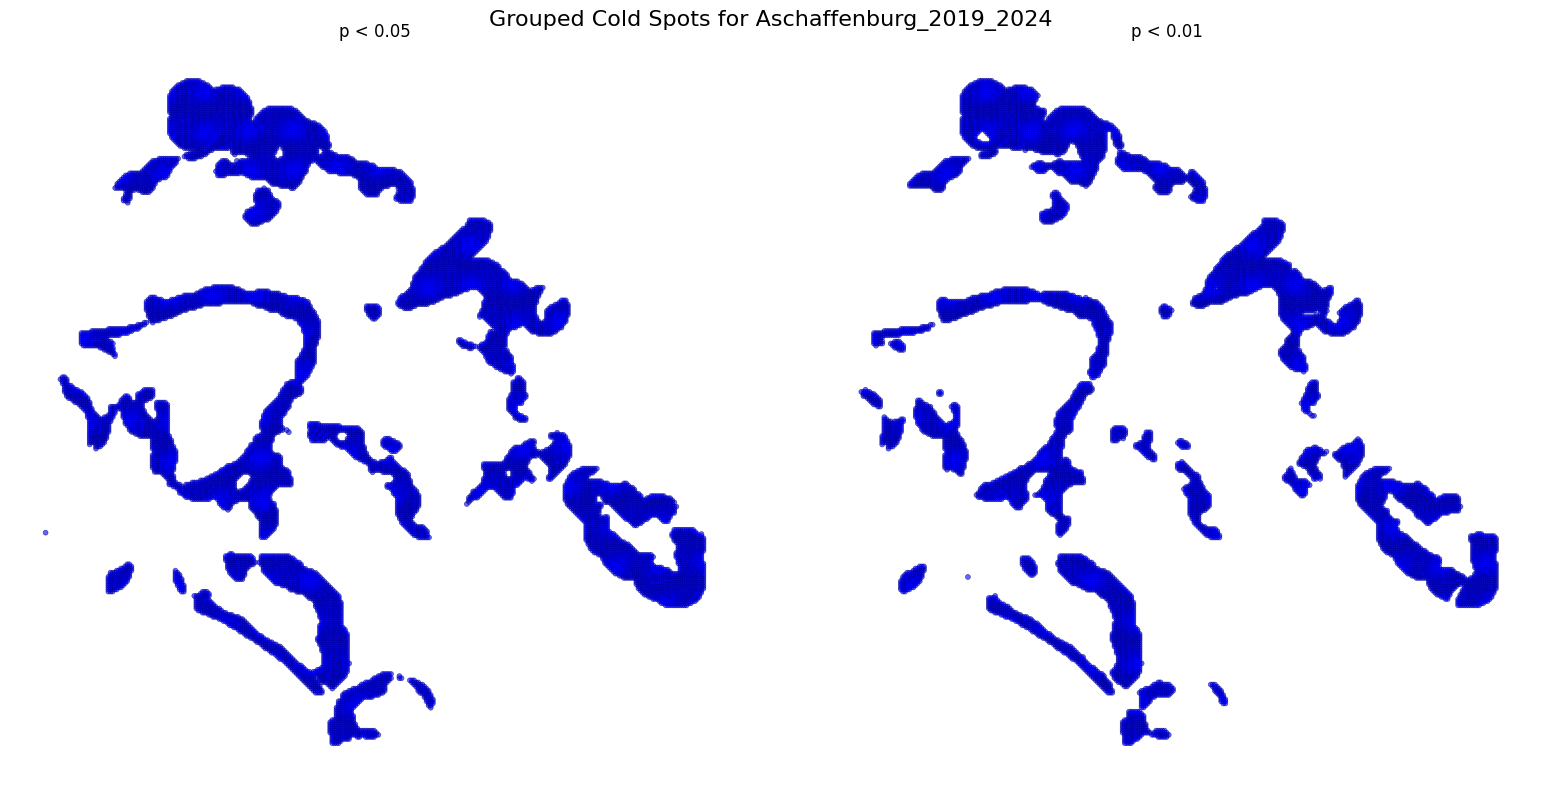


Processing results file: Augsburg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Augsburg_2019_2024
  Successfully loaded Gi* results from Augsburg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Augsburg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Augsburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 28577 islands)
    Created GeoDataFrame with 28768 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Augsburg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Augsburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 20883 islands)
    Created GeoDataFrame with 21016 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Augsburg_2019_2024 (p < 0.01): Source CRS must be an instance of CRS 

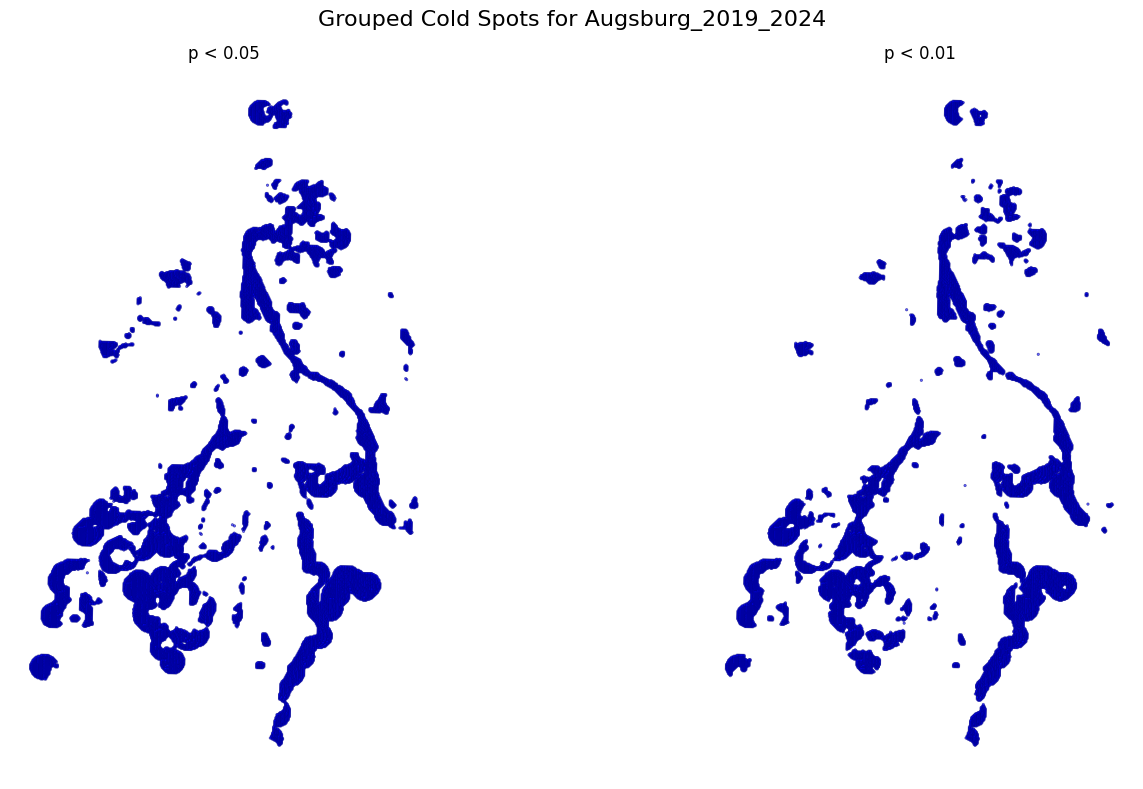


Processing results file: Bamberg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Bamberg_2019_2024
  Successfully loaded Gi* results from Bamberg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Bamberg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Bamberg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 24947 islands)
    Created GeoDataFrame with 24983 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Bamberg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Bamberg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 20097 islands)
    Created GeoDataFrame with 20128 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Bamberg_2019_2024 (p < 0.01): Source CRS must be an instance of CRS or one o

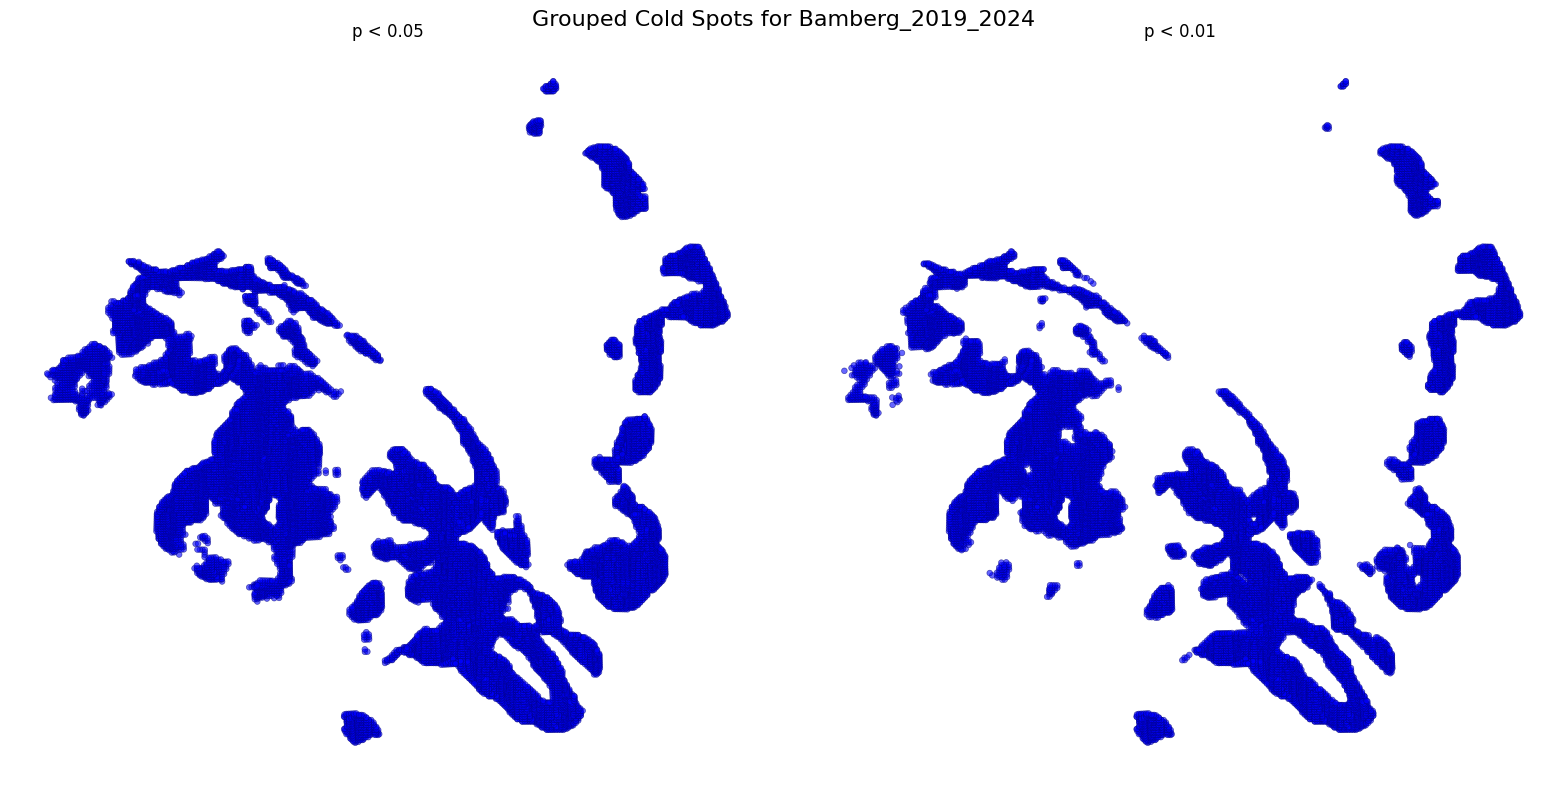


Processing results file: Bayreuth_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Bayreuth_2019_2024
  Successfully loaded Gi* results from Bayreuth_2019_2024_gi_star_2019_results.gpkg
  City boundary for Bayreuth_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Bayreuth_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 29239 islands)
    Created GeoDataFrame with 29397 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Bayreuth_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Bayreuth_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 23300 islands)
    Created GeoDataFrame with 23425 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Bayreuth_2019_2024 (p < 0.01): Source CRS must be an instance of CRS 

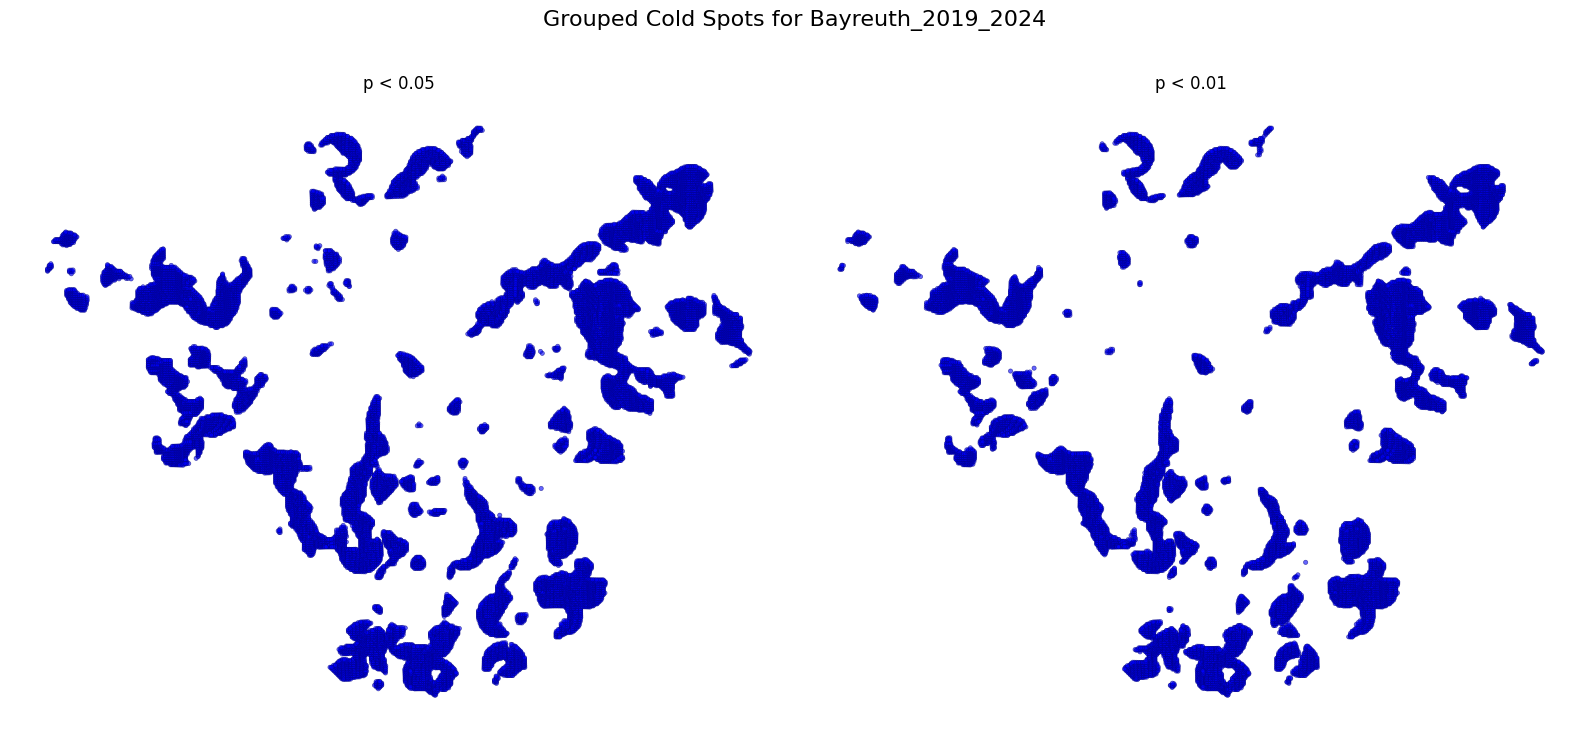


Processing results file: Erlangen_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Erlangen_2019_2024
  Successfully loaded Gi* results from Erlangen_2019_2024_gi_star_2019_results.gpkg
  City boundary for Erlangen_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Erlangen_2019_2024...
[PySAL Warning]  165,  641,  642,  643,  644,  645,  646,  647,  648,  649 ... (total 19073 islands)
    Created GeoDataFrame with 19174 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Erlangen_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Erlangen_2019_2024...
[PySAL Warning]  641,  642,  643,  644,  645,  646,  647,  648,  649,  650 ... (total 15113 islands)
    Created GeoDataFrame with 15194 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Erlangen_2019_2024 (p < 0.01)

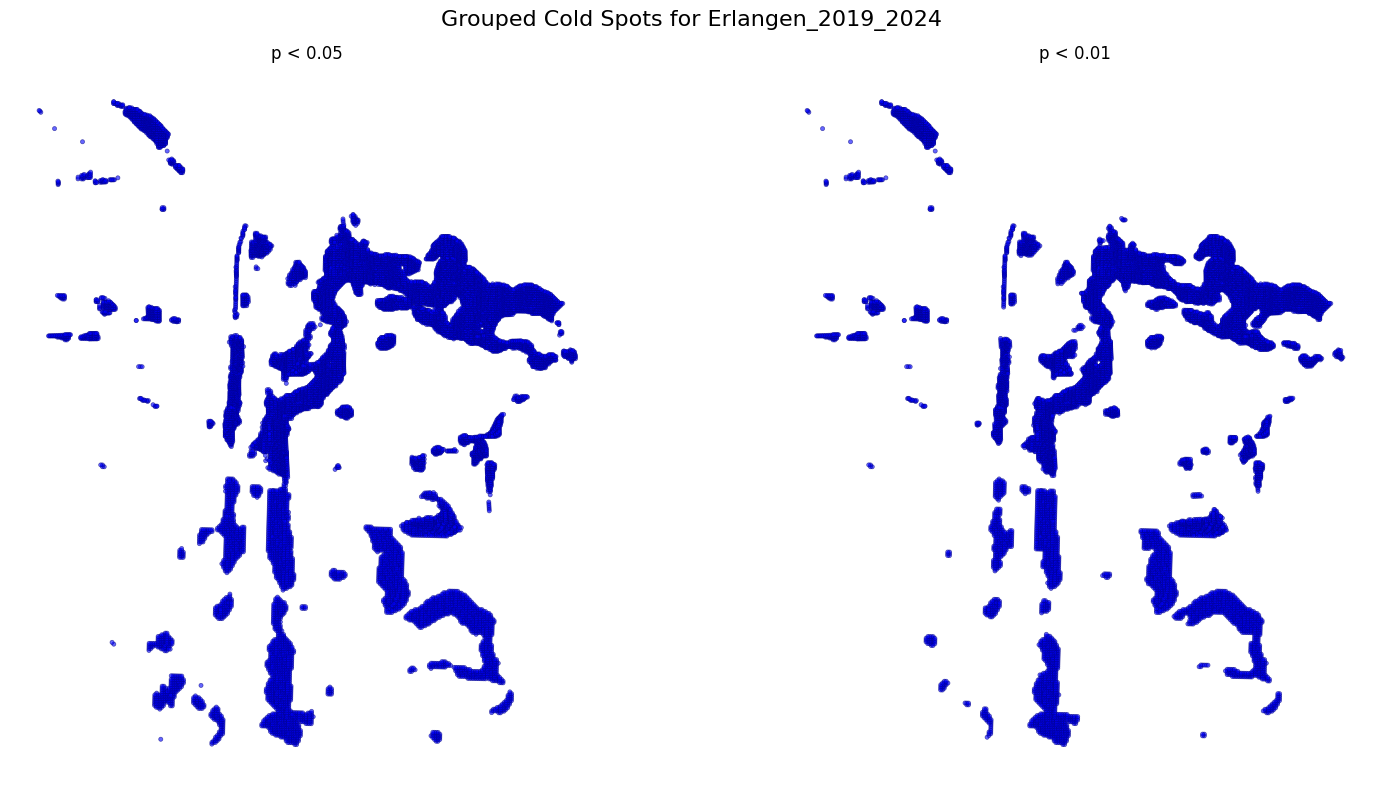


Processing results file: Fürth_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Fürth_2019_2024
  Successfully loaded Gi* results from Fürth_2019_2024_gi_star_2019_results.gpkg
  City boundary for Fürth_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Fürth_2019_2024...
[PySAL Warning]  132,  133,  134,  135,  136,  138,  139,  140,  141,  142 ... (total 15889 islands)
    Created GeoDataFrame with 16041 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Fürth_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Fürth_2019_2024...
[PySAL Warning]  133,  136,  138,  139,  141,  143,  145,  150,  151,  152 ... (total 12386 islands)
    Created GeoDataFrame with 12511 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Fürth_2019_2024 (p < 0.01): Source CRS mus

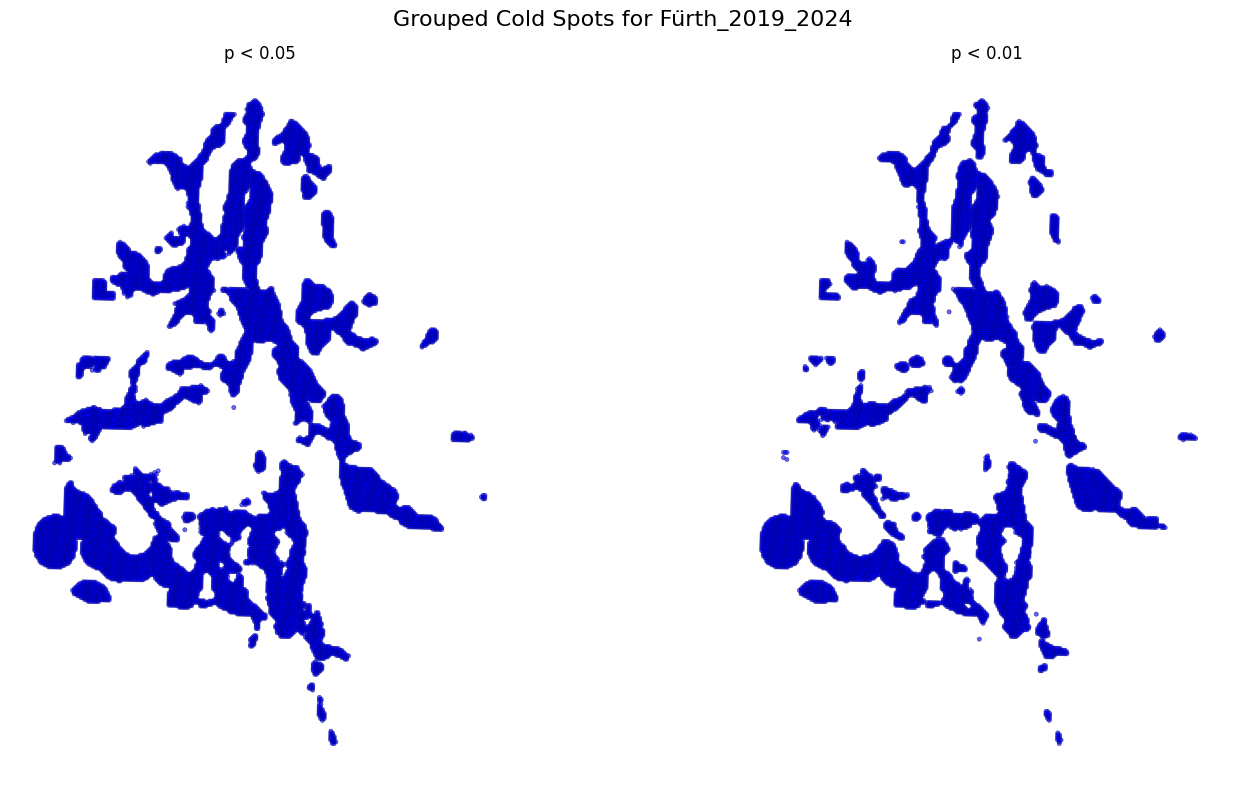


Processing results file: Ingolstadt_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Ingolstadt_2019_2024
  Successfully loaded Gi* results from Ingolstadt_2019_2024_gi_star_2019_results.gpkg
  City boundary for Ingolstadt_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Ingolstadt_2019_2024...
[PySAL Warning]  270,  286,  288,  311,  315,  342,  344,  345,  346,  347 ... (total 23412 islands)
    Created GeoDataFrame with 23717 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Ingolstadt_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Ingolstadt_2019_2024...
[PySAL Warning]  350,  352,  353,  355,  356,  357,  358,  359,  360,  361 ... (total 16720 islands)
    Created GeoDataFrame with 16928 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Ingolstadt_2019

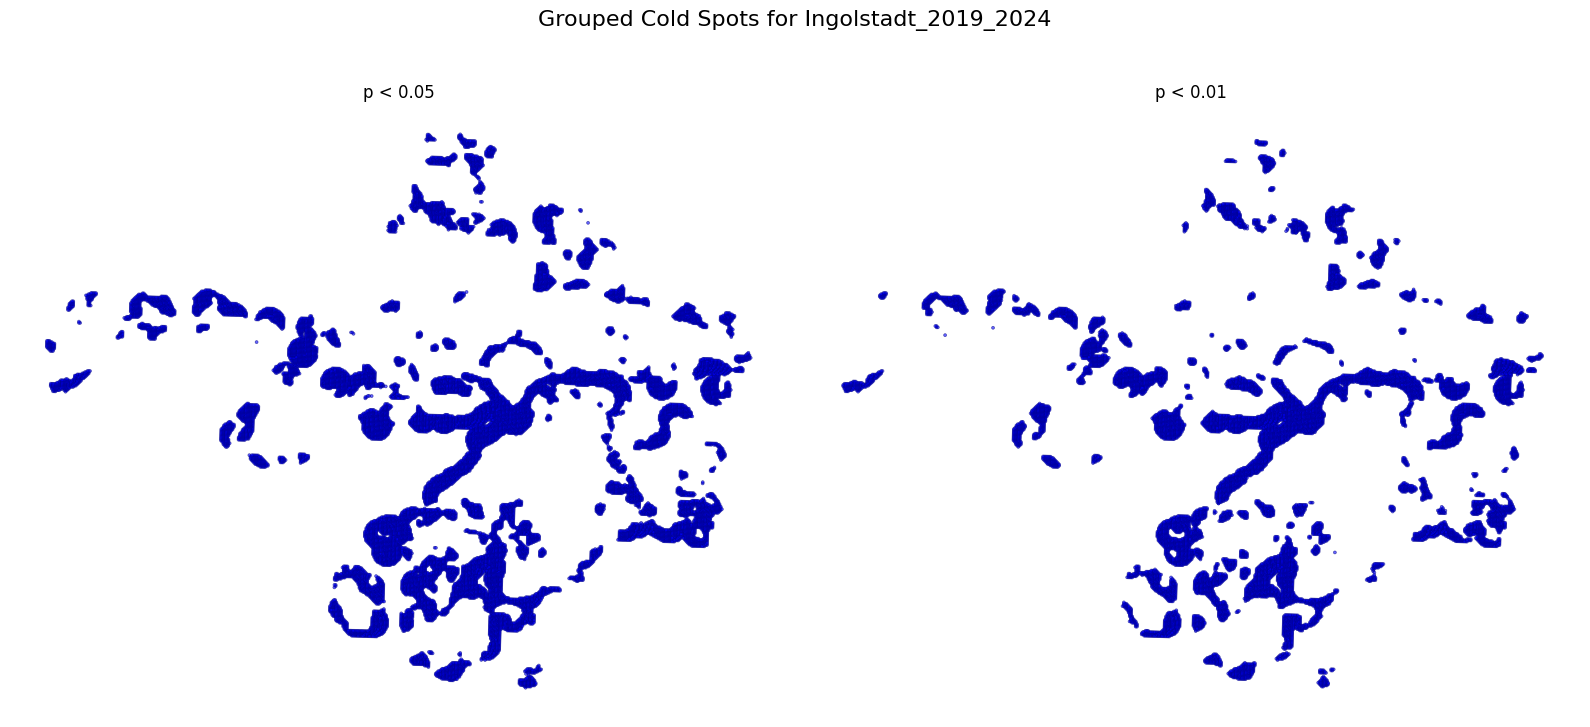


Processing results file: Kempten_(Allgäu)_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Kempten_(Allgäu)_2019_2024
  Successfully loaded Gi* results from Kempten_(Allgäu)_2019_2024_gi_star_2019_results.gpkg
  City boundary for Kempten_(Allgäu)_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Kempten_(Allgäu)_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 22909 islands)
    Created GeoDataFrame with 22909 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Kempten_(Allgäu)_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Kempten_(Allgäu)_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 14467 islands)
    Created GeoDataFrame with 14467 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Kempte

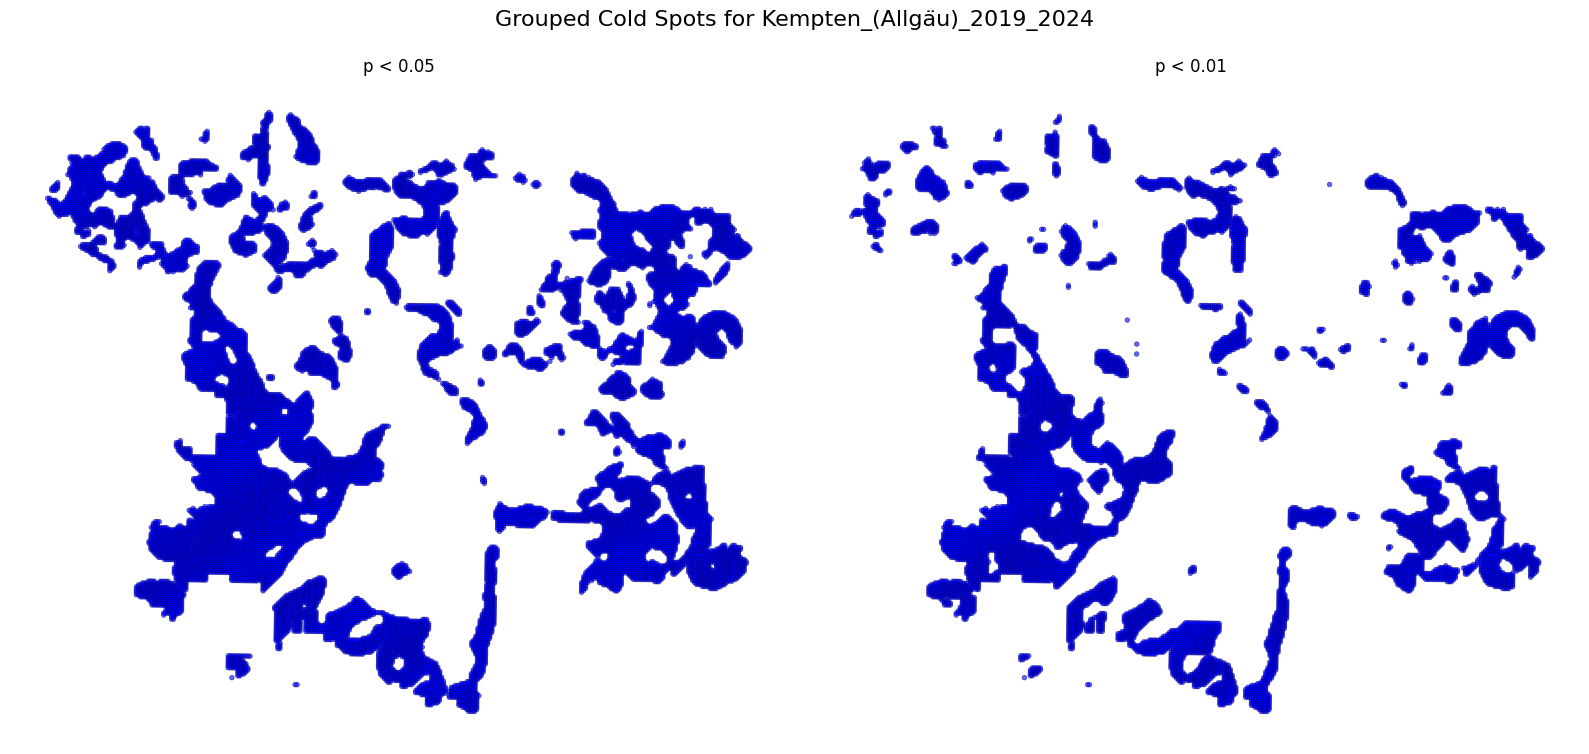


Processing results file: Landshut_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Landshut_2019_2024
  Successfully loaded Gi* results from Landshut_2019_2024_gi_star_2019_results.gpkg
  City boundary for Landshut_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Landshut_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 32453 islands)
    Created GeoDataFrame with 32592 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Landshut_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Landshut_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 25286 islands)
    Created GeoDataFrame with 25404 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Landshut_2019_2024 (p < 0.01): Source CRS must be an instance of CRS 

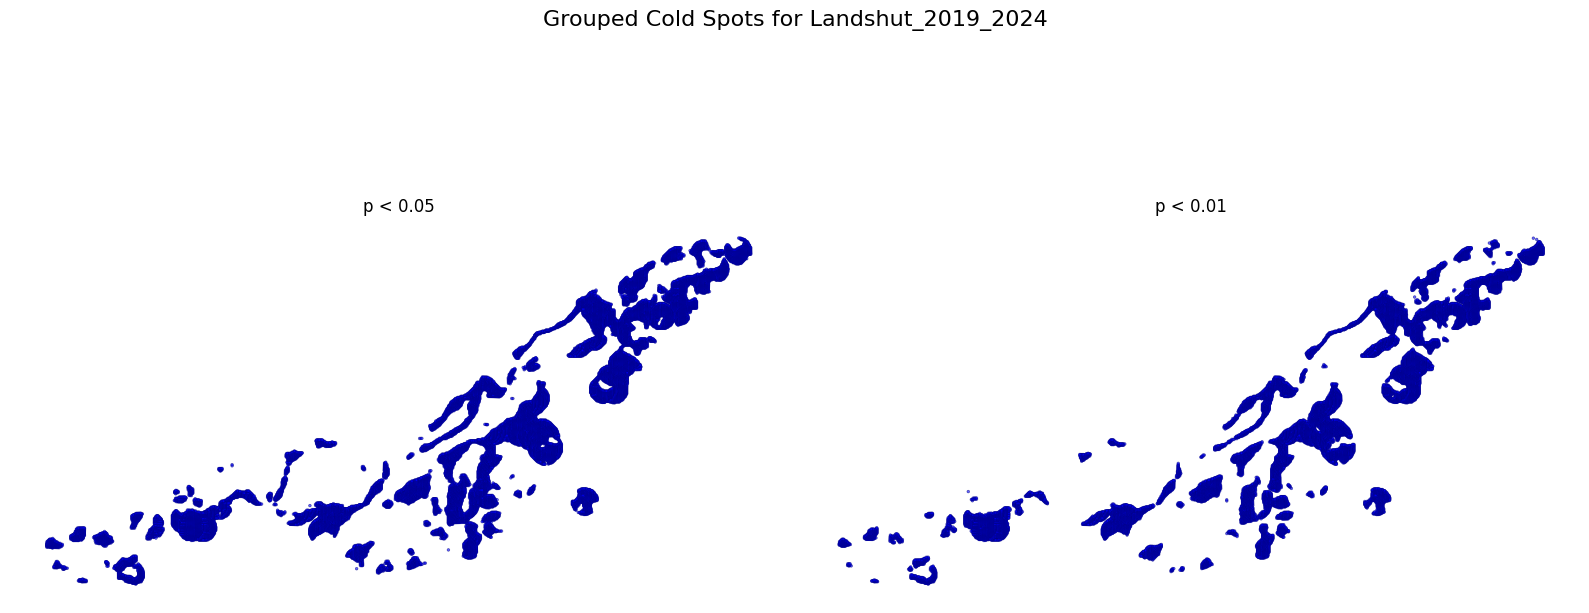


Processing results file: Nuremberg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Nuremberg_2019_2024
  Successfully loaded Gi* results from Nuremberg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Nuremberg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Nuremberg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 44097 islands)
    Created GeoDataFrame with 44545 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Nuremberg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Nuremberg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 36681 islands)
    Created GeoDataFrame with 37036 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Nuremberg_2019_2024 (p < 0.01): Source CRS must be an instance

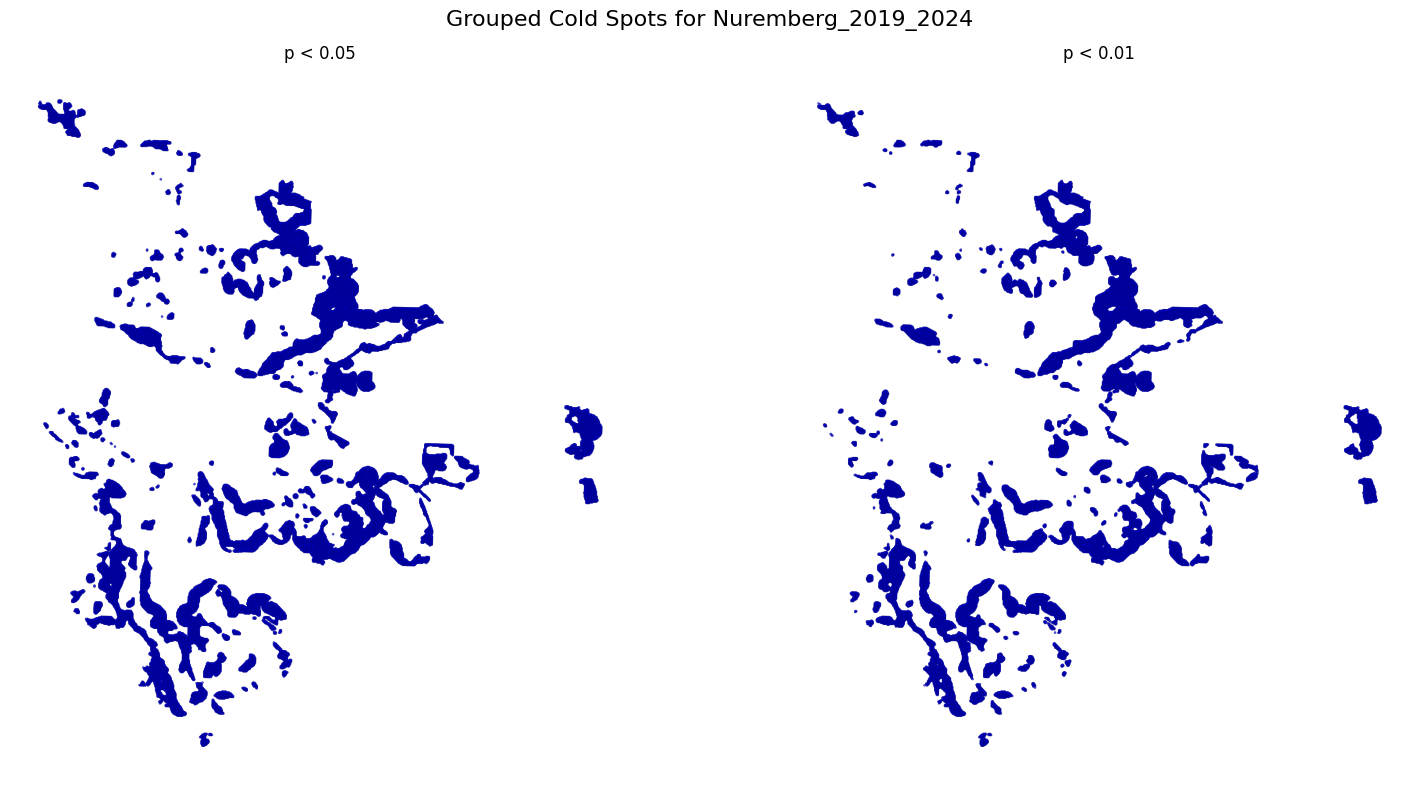


Processing results file: Passau_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Passau_2019_2024
  Successfully loaded Gi* results from Passau_2019_2024_gi_star_2019_results.gpkg
  City boundary for Passau_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Passau_2019_2024...
[PySAL Warning]  0,  3,  4,  5,  6,  7,  8,  9,  10,  11 ... (total 19901 islands)
    Created GeoDataFrame with 20003 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Passau_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Passau_2019_2024...
[PySAL Warning]  4,  5,  6,  7,  8,  9,  10,  11,  12,  13 ... (total 14361 islands)
    Created GeoDataFrame with 14432 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Passau_2019_2024 (p < 0.01): Source CRS must be an instance of CRS or one of 

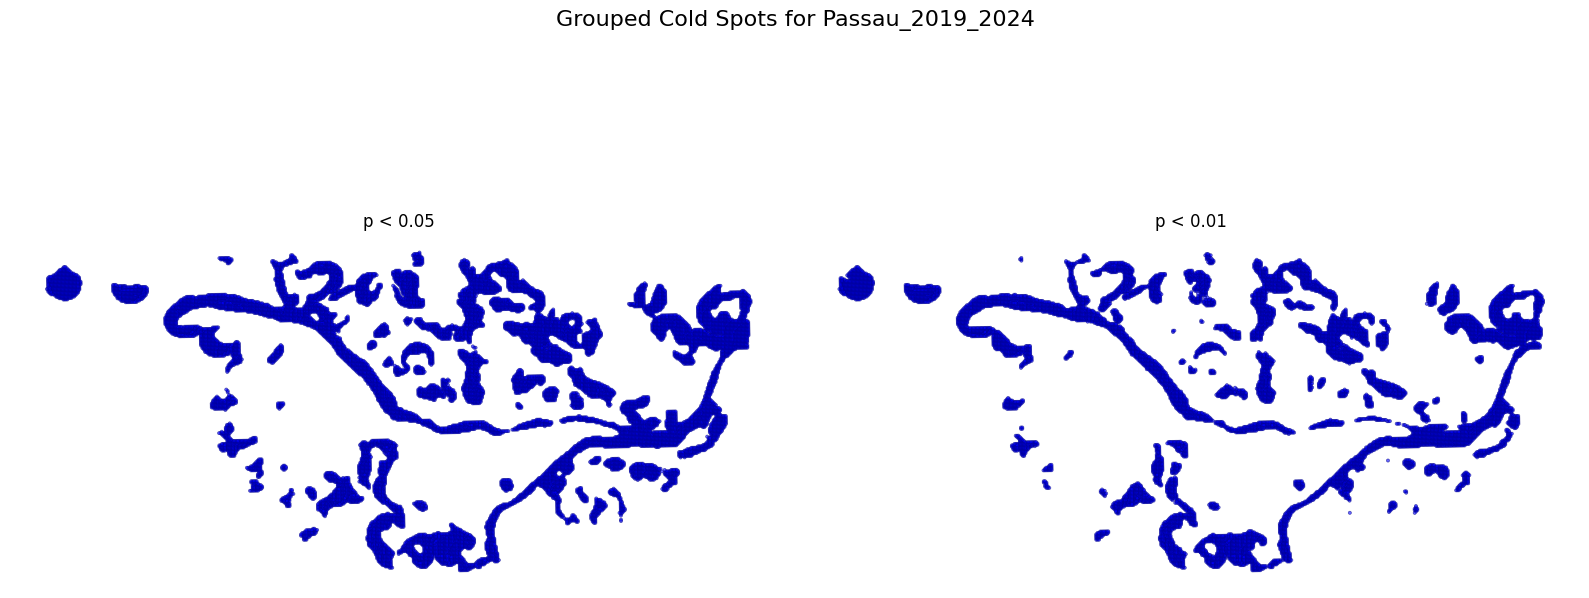


Processing results file: Regensburg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Regensburg_2019_2024
  Successfully loaded Gi* results from Regensburg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Regensburg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Regensburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 36207 islands)
    Created GeoDataFrame with 36485 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Regensburg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Regensburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  7,  8,  9,  10 ... (total 28219 islands)
    Created GeoDataFrame with 28446 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Regensburg_2019_2024 (p < 0.01): Source CRS must be an

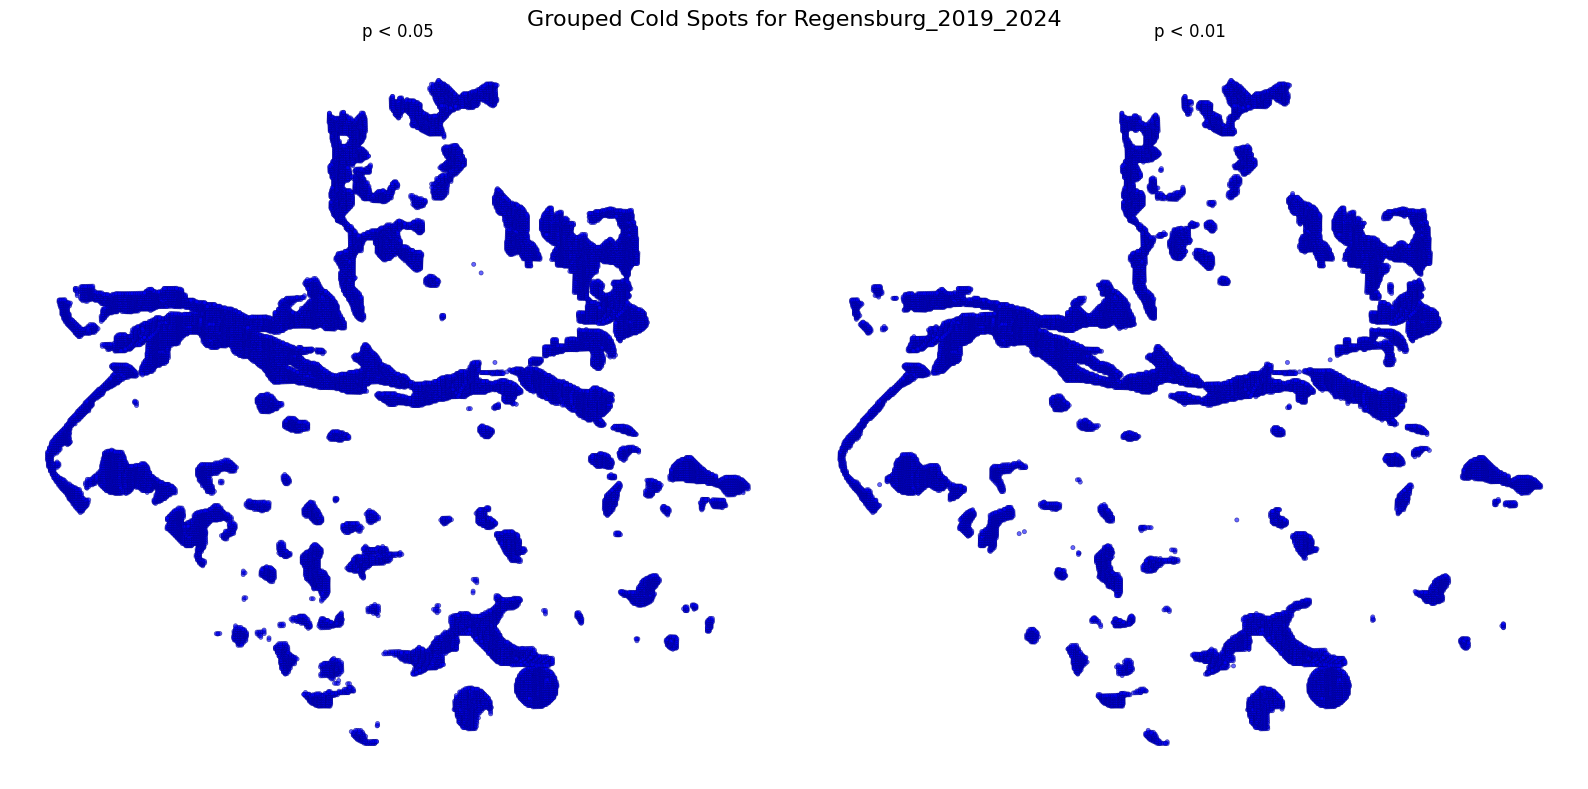


Processing results file: Munich_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Munich_2019_2024
  Successfully loaded Gi* results from Munich_2019_2024_gi_star_2019_results.gpkg
  City boundary for Munich_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Munich_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  10,  11,  12,  15 ... (total 79713 islands)
    Created GeoDataFrame with 81150 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Munich_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Munich_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  10,  11,  12,  15 ... (total 62789 islands)
    Created GeoDataFrame with 63931 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Munich_2019_2024 (p < 0.01): Source CRS must be an instance of CRS or one o

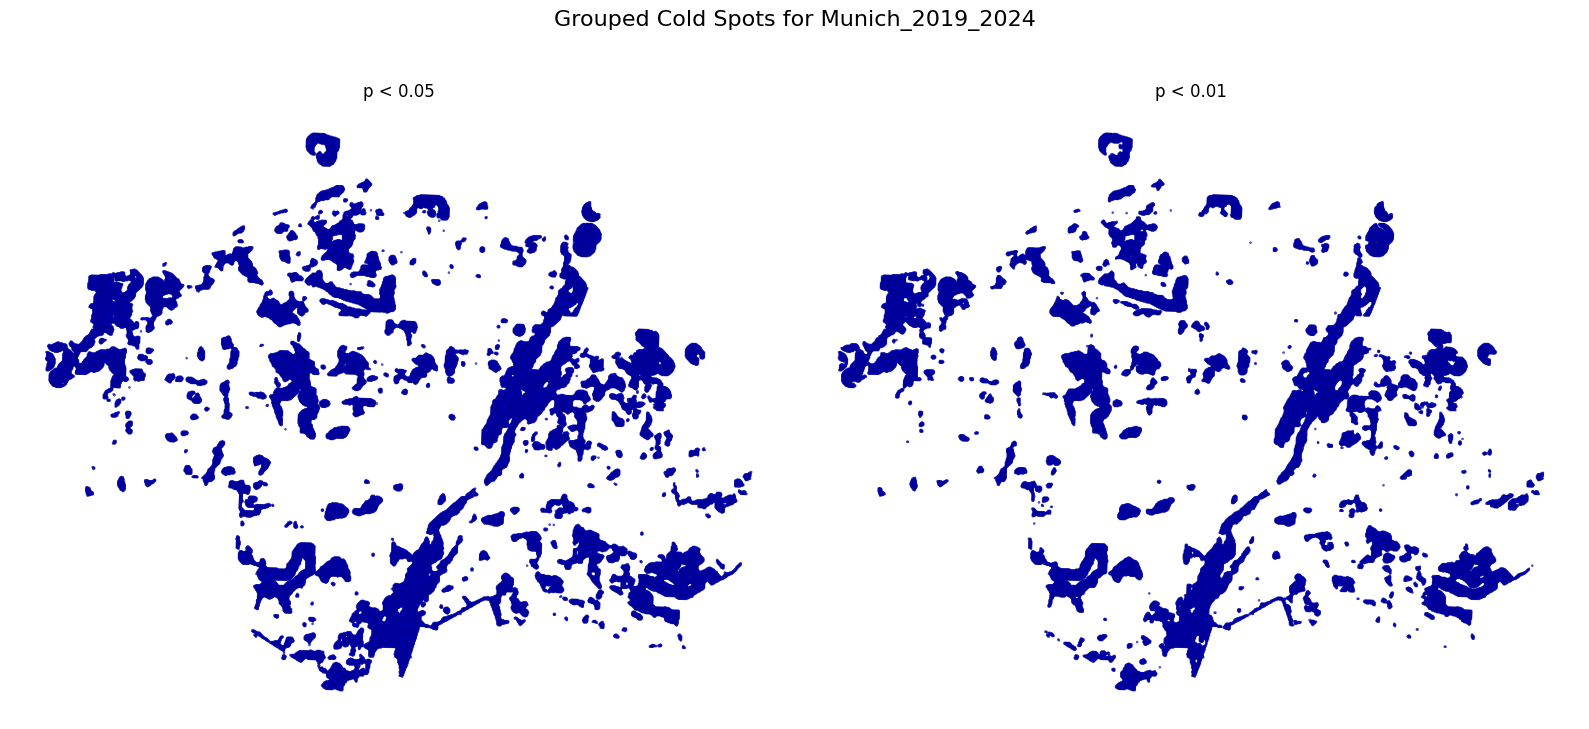


Processing results file: Rosenheim_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Rosenheim_2019_2024
  Successfully loaded Gi* results from Rosenheim_2019_2024_gi_star_2019_results.gpkg
  City boundary for Rosenheim_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Rosenheim_2019_2024...
[PySAL Warning]  11,  12,  13,  15,  16,  17,  18,  19,  20,  21 ... (total 13870 islands)
    Created GeoDataFrame with 14125 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Rosenheim_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Rosenheim_2019_2024...
[PySAL Warning]  22,  23,  25,  26,  27,  28,  29,  57,  58,  59 ... (total 10300 islands)
    Created GeoDataFrame with 10481 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Rosenheim_2019_2024 (p < 0.01): Source CRS

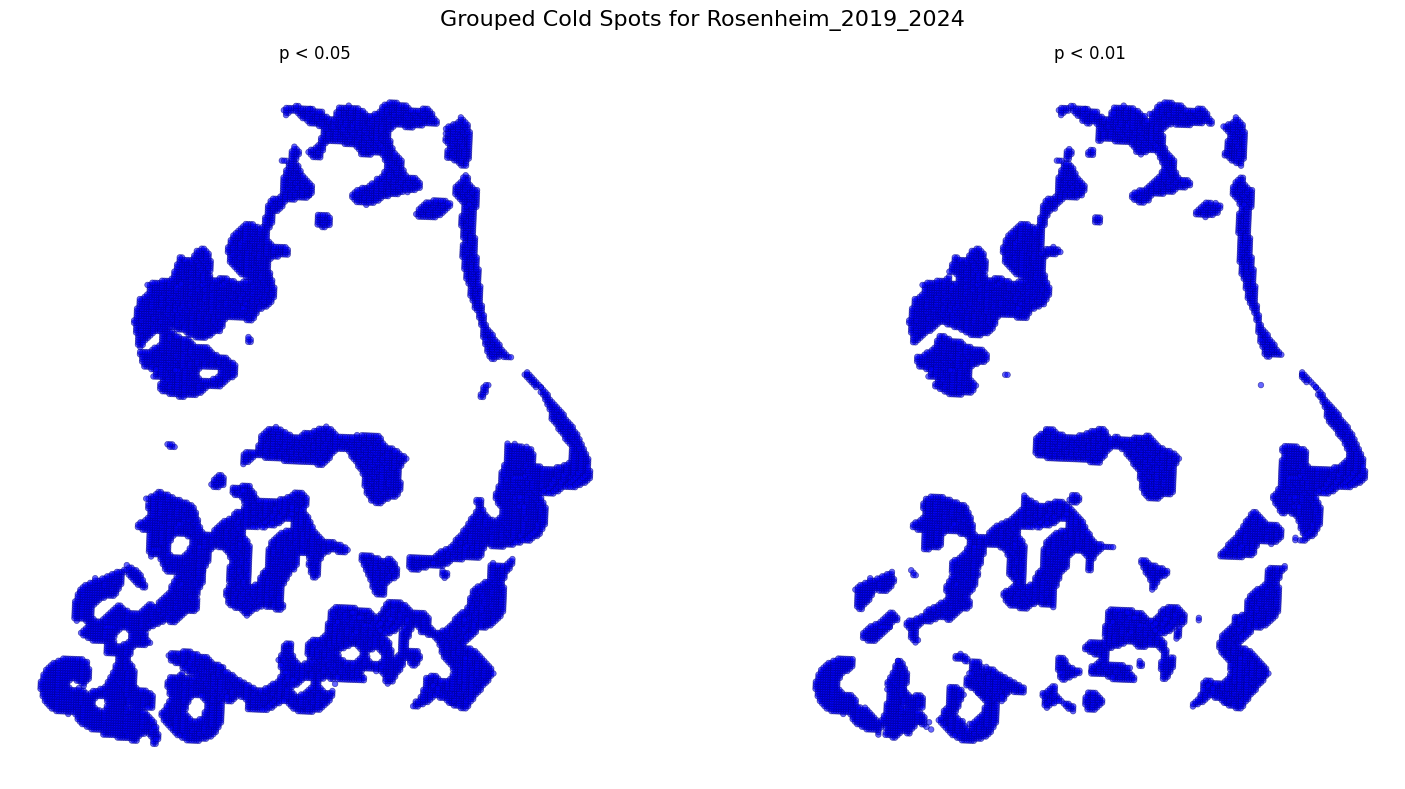


Processing results file: Schweinfurt_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Schweinfurt_2019_2024
  Successfully loaded Gi* results from Schweinfurt_2019_2024_gi_star_2019_results.gpkg
  City boundary for Schweinfurt_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Schweinfurt_2019_2024...
[PySAL Warning]  406,  408,  409,  411,  412,  413,  414,  420,  421,  422 ... (total 6645 islands)
    Created GeoDataFrame with 6665 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Schweinfurt_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Schweinfurt_2019_2024...
[PySAL Warning]  409,  411,  412,  413,  414,  423,  424,  431,  432,  433 ... (total 5525 islands)
    Created GeoDataFrame with 5540 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Schweinfurt_

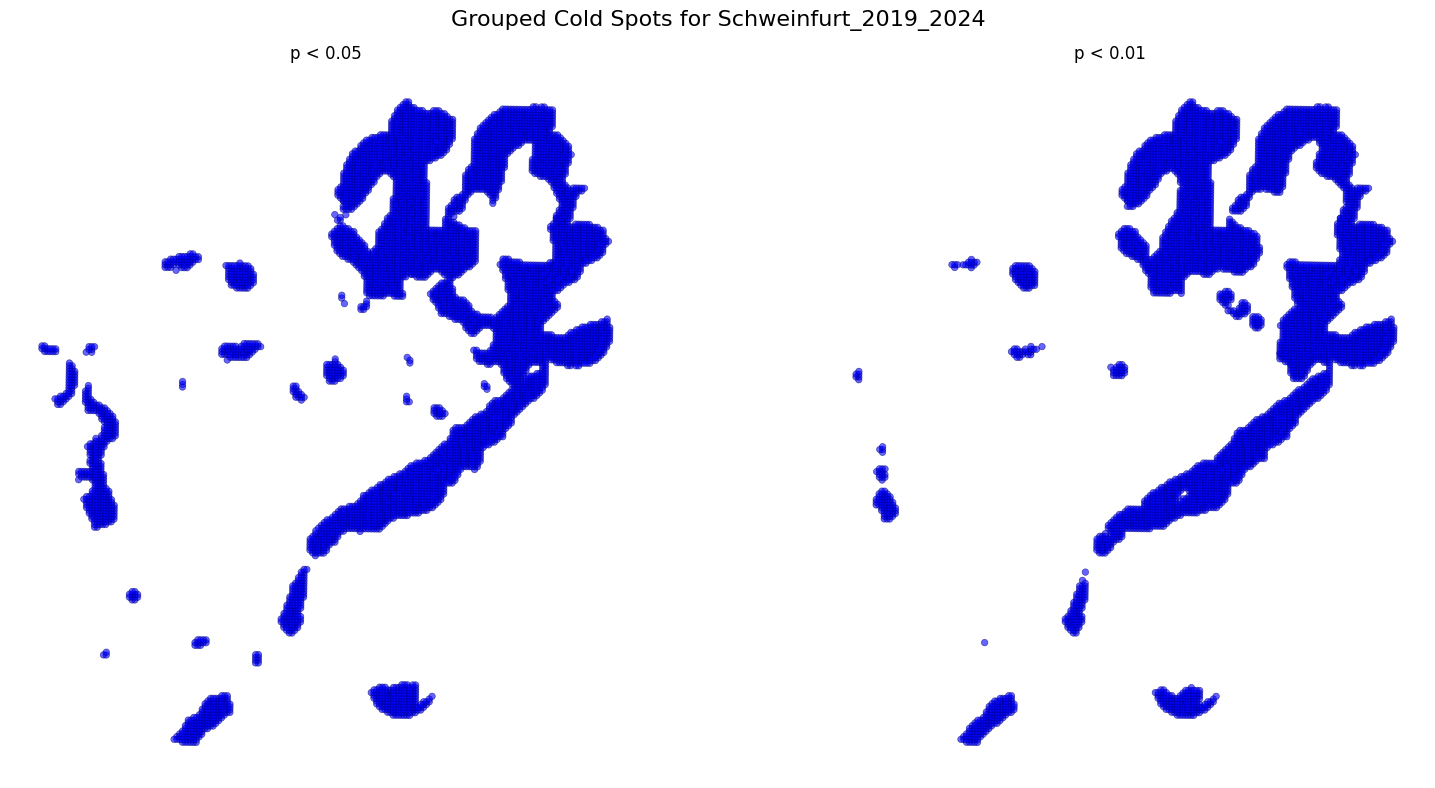


Processing results file: Würzburg_2019_2024_gi_star_2019_results.gpkg
  Extracted City: Würzburg_2019_2024
  Successfully loaded Gi* results from Würzburg_2019_2024_gi_star_2019_results.gpkg
  City boundary for Würzburg_2019_2024 not found in bayern_grenzen_gdf. City boundary will not be plotted.
  - Filtering cold spots with p < 0.05 for Würzburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 20189 islands)
    Created GeoDataFrame with 20254 grouped cold spot polygons for p < 0.05.
  Fehler beim Hinzufügen der Basemap für Würzburg_2019_2024 (p < 0.05): Source CRS must be an instance of CRS or one of its subclasses, or None.
  - Filtering cold spots with p < 0.01 for Würzburg_2019_2024...
[PySAL Warning]  0,  1,  2,  3,  4,  5,  6,  7,  8,  9 ... (total 16351 islands)
    Created GeoDataFrame with 16404 grouped cold spot polygons for p < 0.01.
  Fehler beim Hinzufügen der Basemap für Würzburg_2019_2024 (p < 0.01): Source CRS must be an instance

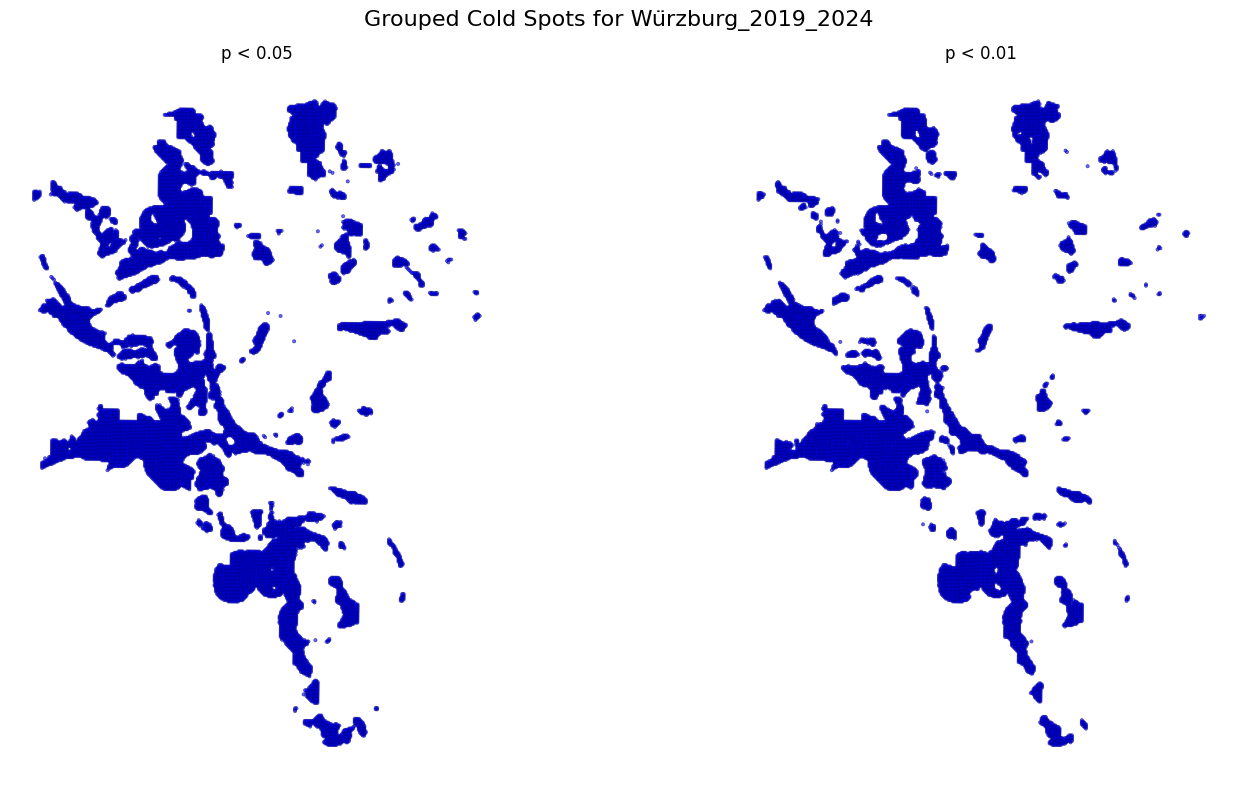

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from libpysal.weights import Queen
from scipy.sparse.csgraph import connected_components
import warnings
import os
import re
import unicodedata
import numpy as np # Import numpy for checking finite bounds
import cartopy.crs as ccrs # Import cartopy for projections
import pandas as pd # Import pandas for concat

# Custom Warning Handler
# Suppress specific FutureWarnings from libpysal regarding use_index in Queen.from_dataframe
warnings.filterwarnings("ignore", category=FutureWarning, module="libpysal.weights.contiguity")
warnings.filterwarnings("ignore", category=DeprecationWarning, message="The 'unary_union' attribute is deprecated") # Suppress DeprecationWarning for unary_union

def custom_warning(message, category, filename, lineno, file=None, line=None):
    msg = str(message)
    if "There are" in msg and "islands with ids:" in msg:
        # IDs-Teil abschneiden und kürzen
        ids_str = msg.split("ids:")[1]
        ids = ids_str.split(",")
        preview = ", ".join(ids[:10])  # erste 10 IDs
        print(f"[PySAL Warning] {preview} ... (total {len(ids)} islands)")
    else:
        # alle anderen Warnings normal ausgeben
        print(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = custom_warning


# Define the directory where Gi* results are saved in Google Drive
gi_results_dir = "/content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer"

# Define the output directory for saving filtered and buffered cold spots
output_filtered_cold_spots_dir = "/content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer_gefiltert"

# Ensure the output directory exists, create if not
if not os.path.exists(output_filtered_cold_spots_dir):
    os.makedirs(output_filtered_cold_spots_dir)
    print(f"Created output directory: {output_filtered_cold_spots_dir}")


# Define the significance thresholds to visualize and their order
significance_thresholds = {
    'p_0.05': {'p_threshold': 0.05, 'label': 'p < 0.05'},
    'p_0.01': {'p_threshold': 0.01, 'label': 'p < 0.01'}
}
# Define the order of thresholds for plotting
threshold_order = ['p_0.05', 'p_0.01'] # Ensure plotting order

buffer_distance_meters = 35 # 30m Größe der Pixel, plus 5m um Überlappungen sicherzustellen

# Assuming bayern_grenzen_gdf is loaded and contains city boundaries.
# If not, you might need to load it here or skip plotting boundaries.
# Example loading (if needed):
bayern_grenzen_path = ("/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg")
try:
    bayern_grenzen_gdf = gpd.read_file(bayern_grenzen_path)
    print("City boundaries loaded.")
except Exception as e:
    print(f"Error loading city boundaries: {e}. City boundaries will not be plotted.")
    bayern_grenzen_gdf = None # Set to None if loading fails


# Function to normalize city names for matching (should match the one used when saving)
def normalize_city_name_for_lookup(city_name):
    normalized_name = unicodedata.normalize('NFKD', city_name).encode("ascii", "ignore").decode("ascii")
    normalized_name = re.sub(r'[^a-zA-Z0-9]', '', normalized_name).strip().lower()
    return normalized_name

# List all GeoPackage files in the Gi* results directory
try:
    gi_files = [f for f in os.listdir(gi_results_dir) if f.endswith(".gpkg")]
    print(f"Found {len(gi_files)} .gpkg files in {gi_results_dir}")
except FileNotFoundError:
    print(f"Error: Gi* results directory not found at {gi_results_dir}")
    gi_files = [] # Initialize as empty list if folder not found

# Iterate through each Gi* results file
for file_name in gi_files:
    print(f"\nProcessing results file: {file_name}")

    # Extract city name from the filename (e.g., Würzburg_gi_star_2024_results.gpkg)
    match = re.match(r'(.*?)_gi_star_\d{4}_results\.gpkg', file_name) # Updated regex to include year
    if match:
        city_name = match.group(1)
        print(f"  Extracted City: {city_name}")
    else:
        print(f"  Warning: Could not parse city name or year from filename {file_name}. Skipping.")
        continue

    # Define the full path to the Gi* results file
    gi_file_path = os.path.join(gi_results_dir, file_name)

    # --- Load the Gi* results GeoDataFrame ---
    try:
        gi_star_gdf = gpd.read_file(gi_file_path, layer='gi_star_results')
        print(f"  Successfully loaded Gi* results from {file_name}")

        # Ensure the loaded gdf has a valid CRS
        if gi_star_gdf.crs is None:
             print(f"  Warning: Loaded Gi* results for {city_name} has no CRS. Assuming EPSG:4326.")
             gi_star_gdf.set_crs(epsg=4326, inplace=True)


    except Exception as e:
        print(f"  Error loading Gi* results from {file_name}: {e}")
        print("  Skipping processing and visualization for this city.")
        continue # Skip to the next file if loading fails


    # --- Prepare City Boundary for Visualization (if available) ---
    city_boundary_3857_plot = None
    if 'bayern_grenzen_gdf' in locals() and bayern_grenzen_gdf is not None:
        # Normalize the current city name for matching with boundaries
        normalized_city_name_for_boundary = normalize_city_name_for_lookup(city_name)

        # Find the corresponding city boundary
        city_boundary_to_visualize = bayern_grenzen_gdf[
            bayern_grenzen_gdf['name'].apply(normalize_city_name_for_lookup) == normalized_city_name_for_boundary
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        if not city_boundary_to_visualize.empty:
             # Ensure boundary gdf is in EPSG:4326 for consistent reprojection
             if city_boundary_to_visualize.crs is None or city_boundary_to_visualize.crs.to_string() != 'EPSG:4326':
                  print(f"  Reprojecting city boundary for {city_name} to EPSG:4326 for plotting.")
                  city_boundary_to_visualize = city_boundary_to_visualize.to_crs(epsg=4326)

             # Reproject to Web Mercator (EPSG:3857) for contextily
             try:
                 city_boundary_3857_plot = city_boundary_to_visualize.to_crs(epsg=3857)
                 print(f"  City boundary for {city_name} reprojected to EPSG:3857 for plotting.")
             except Exception as e:
                 print(f"  Error reprojecting city boundary for {city_name} to EPSG:3857: {e}")
                 print("  City boundary will not be plotted for this city.")
                 city_boundary_3857_plot = None # Set to None if reprojection fails
        else:
             print(f"  City boundary for {city_name} not found in bayern_grenzen_gdf. City boundary will not be plotted.")


    # Reproject the Gi* results gdf to a projected CRS for accurate buffering
    try:
        gi_star_projected = gi_star_gdf.to_crs(epsg=32632)
    except Exception as e:
        print(f"Error reprojecting Gi* results data for {city_name}: {e}")
        print("Skipping processing and visualization for this city.")
        continue # Skip to the next city if reprojection fails

    # List to hold grouped cold spots for different thresholds for this city
    grouped_cold_spots_for_city = []

    # Create a figure with subplots for the significance thresholds, specifying projection for GeoAxes
    fig, axes = plt.subplots(1, len(significance_thresholds), figsize=(len(significance_thresholds) * 8, 8),
                             sharex=True, sharey=True, subplot_kw={'projection': ccrs.epsg(3857)}) # Specify projection

    fig.suptitle(f'Grouped Cold Spots for {city_name}', fontsize=16)

    # Flatten axes array if there's only one subplot
    if len(significance_thresholds) == 1:
        axes = [axes]

    # Iterate through each significance threshold in the defined order
    for i, threshold_key in enumerate(threshold_order):
        threshold_info = significance_thresholds[threshold_key]
        p_thresh = threshold_info['p_threshold']
        label = threshold_info['label']
        ax = axes[i] # Get the correct subplot axis

        print(f"  - Filtering cold spots with {label} for {city_name}...")

        # Filter for cold spots based on the current p-value threshold and negative Z-score
        cold_spots_filtered = gi_star_projected[
            (gi_star_projected['gi_star_p_sim'] <= p_thresh) &
            (gi_star_projected['gi_star_z_sim'] < 0)
        ].copy()

        if cold_spots_filtered.empty:
            print(f"    No cold spots found for {label} in {city_name}.")
            ax.set_title(label)
            ax.set_axis_off()
            # Add basemap even if no cold spots are found, to show the city context
            try:
                # Use city boundary extent if available, otherwise use a default extent or skip basemap
                if city_boundary_3857_plot is not None:
                     # Use set_extent with crs argument for GeoAxes
                     ax.set_extent(city_boundary_3857_plot.total_bounds, crs=city_boundary_3857_plot.crs)
                     ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
                else:
                    # Attempt to add basemap using the extent of the (empty) cold_spots_filtered geodataframe reprojected to 3857
                    if gi_star_gdf.crs is not None:
                         gi_star_3857_extent = gi_star_gdf.to_crs(epsg=3857).total_bounds
                         if np.isfinite(gi_star_3857_extent).all():
                              ax.set_extent(gi_star_3857_extent, crs=gi_star_gdf.to_crs(epsg=3857).crs)
                              ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
                         else:
                              print("    Could not determine extent for basemap.")
                    else:
                         print("    Could not determine extent for basemap.")

            except Exception as e:
                print(f"    Fehler beim Hinzufügen der Basemap für {city_name} ({label}): {e}")
                pass # Continue without basemap if it fails
            continue # Skip to the next threshold if no cold spots are found


        # Create a buffer around each cold spot point (in projected CRS)
        cold_spot_buffers_projected = cold_spots_filtered.buffer(buffer_distance_meters)

        # Create a GeoDataFrame from the buffered polygons (in projected CRS)
        cold_spot_buffers_gdf_projected = gpd.GeoDataFrame(
            cold_spots_filtered.drop(columns=['geometry']), # Keep original attributes
            geometry=cold_spot_buffers_projected,
            crs=cold_spots_filtered.crs
        )

        # Reproject the buffered polygons back to EPSG:4326 for consistency before grouping and saving
        cold_spot_buffers_gdf_4326 = cold_spot_buffers_gdf_projected.to_crs(epsg=4326)

        # Ensure geometries are valid before creating weights and dissolving
        cold_spot_buffers_valid_geom = cold_spot_buffers_gdf_4326.dropna(subset=['geometry']).copy()
        if not cold_spot_buffers_valid_geom.geometry.is_valid.all():
             print("Warning: Some buffered geometries are invalid. Attempting to fix before grouping.")
             # Attempt to fix invalid geometries by buffering by 0
             cold_spot_buffers_valid_geom['geometry'] = cold_spot_buffers_valid_geom.geometry.buffer(0)
             # Drop any rows where buffering by 0 resulted in None or empty geometry
             cold_spot_buffers_valid_geom = cold_spot_buffers_valid_geom[~cold_spot_buffers_valid_geom.geometry.is_empty].copy()


        # Create a Queen contiguity spatial weights matrix for the valid buffered polygons
        try:
            # Use the index from the valid geometries GeoDataFrame
            wq = Queen.from_dataframe(cold_spot_buffers_valid_geom, use_index=True)
            #print(f"    Queen contiguity weights matrix created for {city_name} ({threshold_key}).")

            # Identify connected components in the weights matrix
            # This groups polygons that are connected (touching or overlapping)
            n_components, component_labels = connected_components(wq.sparse)
            #print(f"    Identified {n_components} connected components (groups).")

            # Add component labels to the buffered polygons GeoDataFrame
            cold_spot_buffers_valid_geom['group_id'] = component_labels

            # Dissolve the buffered polygons based on the group_id
            # This merges all polygons within the same group into a single multi-polygon feature
            # Keep original attributes by default (first value in each group)
            grouped_cold_spots = cold_spot_buffers_valid_geom.dissolve(by='group_id', as_index=False)

            print(f"    Created GeoDataFrame with {len(grouped_cold_spots)} grouped cold spot polygons for {label}.")

            # Add a column to indicate the significance level
            grouped_cold_spots['significance_level'] = label

            # Append to the list for this city
            grouped_cold_spots_for_city.append(grouped_cold_spots)


            # --- Visualization ---
            # Reproject the grouped cold spots to Web Mercator (EPSG:3857) for contextily
            if grouped_cold_spots.crs is None:
                 print(f"Warning: Grouped cold spots for {city_name} ({label}) has no CRS. Assuming EPSG:4326 and reprojecting for plotting.")
                 grouped_cold_spots.set_crs(epsg=4326, inplace=True)

            if grouped_cold_spots.crs.to_string() != 'EPSG:3857':
                try:
                    grouped_cold_spots_3857 = grouped_cold_spots.to_crs(epsg=3857)
                except Exception as e:
                     print(f"Error reprojecting grouped cold spots for {city_name} ({label}) to EPSG:3857: {e}")
                     print("Skipping plotting for this subplot.")
                     ax.set_title(f"{label}\n(Plot Error)")
                     ax.set_axis_off()
                     continue # Skip plotting this subplot but continue with others
            else:
                # Corrected variable name from 3877 to 3857
                grouped_cold_spots_3857 = grouped_cold_spots


            # Plot the city boundary on the current subplot (if available)
            if city_boundary_3857_plot is not None:
                 # Use GeoDataFrame.plot directly on the GeoAxes
                 city_boundary_3857_plot.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, label=f'{city_name} Boundary') # Reduced linewidth for subplots

            # Plot the grouped cold spots on the current subplot
            # Use GeoDataFrame.plot directly on the GeoAxes
            grouped_cold_spots_3857.plot(ax=ax, facecolor='blue', alpha=0.6, edgecolor='navy', linewidth=0.5, label=label) # Reduced linewidth and increased alpha slightly


            # Add basemap (OpenStreetMap) to the current subplot
            try:
                # Use the extent of the plotted data for the basemap
                # This ensures the basemap covers the area of the cold spots and boundary
                # Set the extent of the axes to the combined bounds of the plotted data
                # Get total bounds in the plotting CRS (EPSG:3857)
                all_data_3857 = [grouped_cold_spots_3857]
                if city_boundary_3857_plot is not None:
                    all_data_3857.append(city_boundary_3857_plot)

                # Calculate total bounds from the list of GeoDataFrames/GeoSeries
                # Using GeoDataFrame.total_bounds directly on the list of GeoDataFrames
                # Use union_all() method instead of deprecated unary_union attribute
                total_bounds_geoseries = gpd.GeoSeries([g.geometry.union_all() for g in all_data_3857 if not g.empty])
                if not total_bounds_geoseries.empty:
                    total_bounds = total_bounds_geoseries.total_bounds
                else:
                    total_bounds = []


                if np.isfinite(total_bounds).all():
                     # set_extent expects (minx, miny, maxx, maxy)
                     # Determine the CRS for set_extent based on the plotted data CRS (EPSG:3857)
                     plot_crs = grouped_cold_spots_3857.crs if not grouped_cold_spots_3857.empty else (city_boundary_3857_plot.crs if city_boundary_3857_plot is not None else None)
                     if plot_crs:
                         ax.set_extent(total_bounds, crs=plot_crs) # Use the CRS of the plotted data
                         ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
                         print(f"  Basemap added for {city_name} ({label}).")
                     else:
                         print("  Could not determine CRS for set_extent.")
                else:
                     print(f"  Could not determine valid extent for basemap for {city_name} ({label}).")


            except Exception as e:
                print(f"  Fehler beim Hinzufügen der Basemap für {city_name} ({label}): {e}")
                pass # Continue without basemap if it fails


            # Set title for the subplot
            ax.set_title(label)
            ax.set_axis_off() # Turn off axis for map plots

        except Exception as e:
            print(f"  Error during grouping or visualization for {city_name} ({threshold_key}): {e}")
            print("  Skipping visualization for this subplot.")
            ax.set_title(f"{label}\n(Error)")
            ax.set_axis_off() # Turn off axis even on error

    # --- Save the combined filtered and grouped cold spots for this city ---
    if grouped_cold_spots_for_city: # Check if any cold spots were found for this city
        combined_grouped_cold_spots = pd.concat(grouped_cold_spots_for_city, ignore_index=True)

        # Define the output path for the GeoPackage file for the current city
        # This file will contain cold spots for both thresholds
        output_gpkg_path = os.path.join(output_filtered_cold_spots_dir, f"{city_name}_cold_spots_combined_2019_2024.gpkg")

        # Ensure the GeoDataFrame has a valid CRS before saving (using the CRS from the first grouped gdf)
        if combined_grouped_cold_spots.crs is None and grouped_cold_spots_for_city[0].crs is not None:
             print(f"Warning: Combined GeoDataFrame for {city_name} has no CRS. Assigning CRS from first threshold result ({grouped_cold_spots_for_city[0].crs}) for saving.")
             combined_grouped_cold_spots.set_crs(grouped_cold_spots_for_city[0].crs, inplace=True)


        try:
            # Save the combined grouped cold spots GeoDataFrame
            combined_grouped_cold_spots.to_file(output_gpkg_path, driver='GPKG')
            print(f"  Successfully saved combined grouped cold spots for {city_name} to: {output_gpkg_path}")
        except Exception as e:
            print(f"  Error saving combined grouped cold spots for {city_name} to GeoPackage file: {e}")


    plt.tight_layout()
    plt.show()

erfolgreich alle Cold Spot Analysen durchgeführt